/tmp/ipykernel_26850/210244125.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


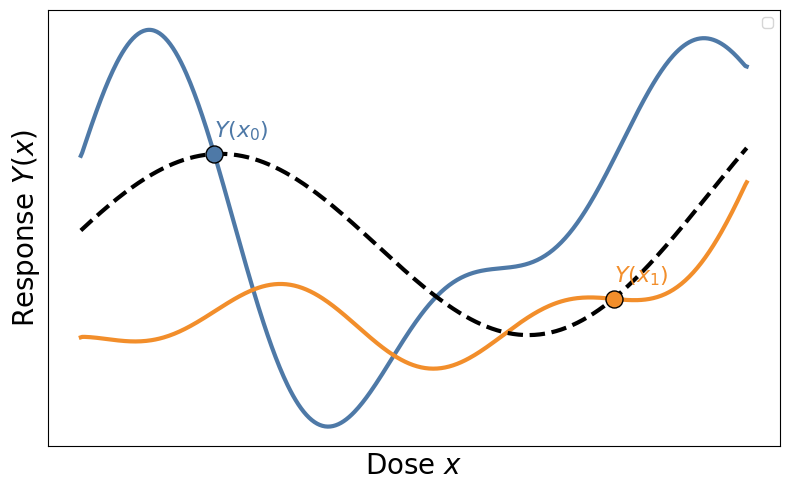

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import logging

# suppress font_manager spam
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# reproducibility
np.random.seed(100)

# Reset to default style
plt.rcdefaults()

# Define the true dose-response
def true_response(x):
    return np.sin(x / 1.5) + 0.1 * x + 0.5 * np.cos(x / 2)

# Grid and true curve
x = np.linspace(0, 10, 500)
y_true = true_response(x)

# Intervention points
baseline_xs = [2, 8]
baseline_ys = true_response(np.array(baseline_xs))

# Colors
true_color = 'black'
curve_colors = ['#4E79A7', '#F28E2B']

plt.figure(figsize=(8, 5))

# Plot random transport curves
t = 0
for i, (x0, y0) in enumerate(zip(baseline_xs, baseline_ys)):
    # Low-frequency warp
    warp = np.zeros_like(x)
    for k in range(1, 4):
        warp += (np.random.normal(scale=1) * np.sin(k * x / 2) +
                 np.random.normal(scale=1) * np.cos(k * x / 3))
    warp = gaussian_filter1d(warp, sigma=1)
    # Anchor
    idx0 = np.argmin(np.abs(x - x0))
    curve = y_true + (warp - warp[idx0])
    plt.plot(x, curve, color=curve_colors[i], linewidth=3)
    # Plot and label intersections
    plt.scatter([x0], [y0], color=curve_colors[i], edgecolor='black', s=150, zorder=5)
    label = r'$Y(x_0)$' if i == 0 else r'$Y(x_1)$'
    plt.text(x0 + 0.0, y0 + 0.2, label, fontsize=16, color = curve_colors[i])

# Plot true curve
plt.plot(x, y_true, color=true_color, linestyle='--', linewidth=3)

# Minimal axes
plt.xticks([])
plt.yticks([])
plt.legend()
plt.xlabel('Dose $x$', fontsize=20)
plt.ylabel('Response $Y(x)$', fontsize=20)
plt.tight_layout()
plt.show()

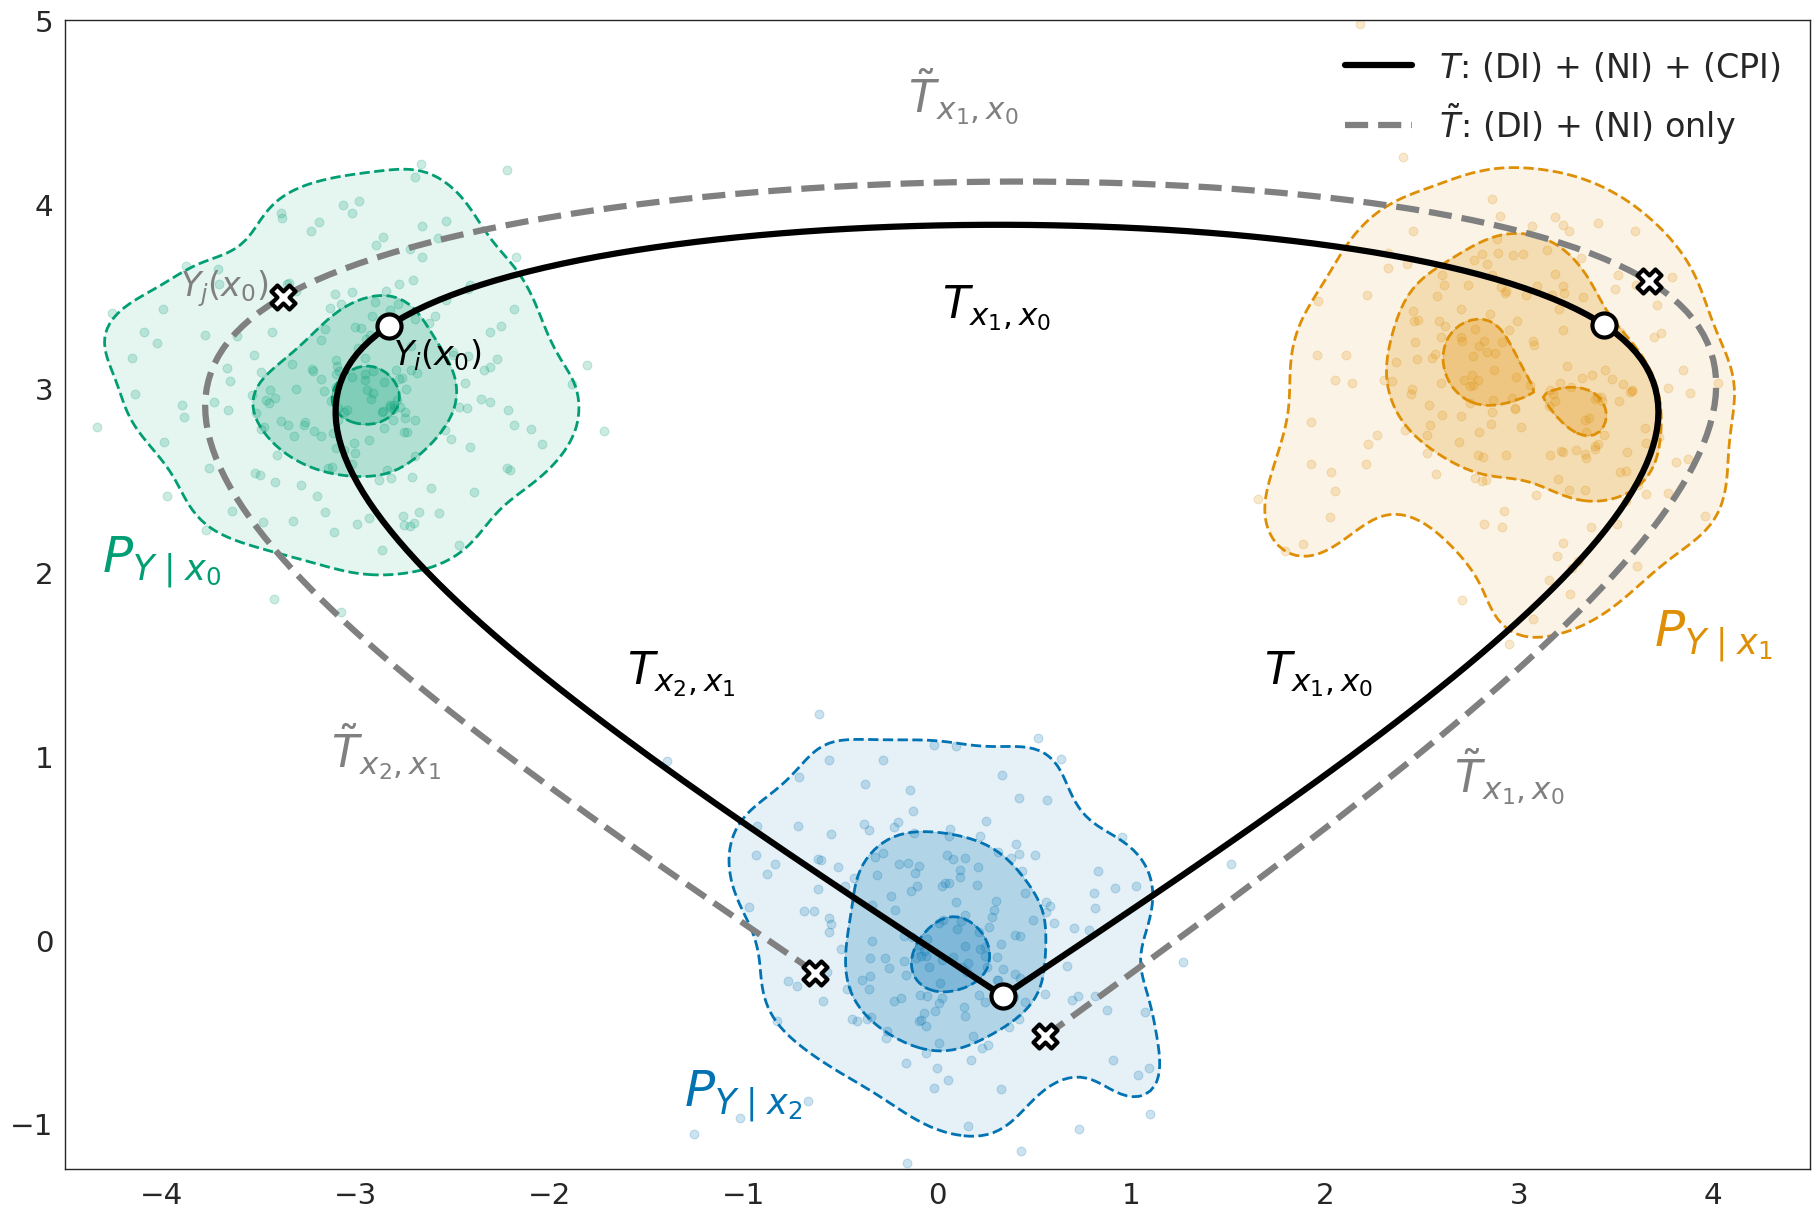

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde
import logging

# Suppress font_manager messages
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Use a clean seaborn style and a colorblind-safe palette
sns.set_style("white")
# double the font_scale from 1.2 to 2.4
sns.set_context("paper", font_scale=2.4)
palette = sns.color_palette("colorblind", 3)

# Reproducibility
np.random.seed(1)

# Cluster means and sampling for KDE/background
mean_P0 = np.array([0, 0])
mean_P1 = np.array([3, 3])
mean_P2 = np.array([-3, 3])
samples0 = np.random.normal(loc=mean_P0, scale=0.5, size=(200, 2))
samples1 = np.random.normal(loc=mean_P1, scale=0.5, size=(200, 2))
samples2 = np.random.normal(loc=mean_P2, scale=0.5, size=(200, 2))

# Grid for KDE
xmin, xmax, ymin, ymax = -4.5, 4.5, -2, 6
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300),
                     np.linspace(ymin, ymax, 300))
grid = np.vstack([xx.ravel(), yy.ravel()])

# Compute KDEs
Z0 = gaussian_kde(samples0.T)(grid).reshape(xx.shape)
Z1 = gaussian_kde(samples1.T)(grid).reshape(xx.shape)
Z2 = gaussian_kde(samples2.T)(grid).reshape(xx.shape)

# Contour levels (fractions of max density)
levels = [0.1, 0.5, 0.9]
L0 = [Z0.max()*lv for lv in levels]
L1 = [Z1.max()*lv for lv in levels]
L2 = [Z2.max()*lv for lv in levels]

# double figure size
fig, ax = plt.subplots(figsize=(18, 12))

# Background scatter for each cluster (s doubled 20→40)
ax.scatter(samples0[:,0], samples0[:,1], color=palette[0], alpha=0.2, s=40)
ax.scatter(samples1[:,0], samples1[:,1], color=palette[1], alpha=0.2, s=40)
ax.scatter(samples2[:,0], samples2[:,1], color=palette[2], alpha=0.2, s=40)

# define opacities for inner→outer
alphas = [0.5, 0.3, 0.1]

for Z, levels, color in zip((Z0, Z1, Z2), (L0, L1, L2), palette):
    low, mid, high = levels   # [10%, 50%, 90%] of peak

    # inner band: 0→10%
    ax.contourf(xx, yy, Z,
                levels=[high, 1],
                colors=[color],
                alpha=alphas[0])

    # middle band: 10%→50%
    ax.contourf(xx, yy, Z,
                levels=[mid, high],
                colors=[color],
                alpha=alphas[1])

    # outer band: 50%→90%
    ax.contourf(xx, yy, Z,
                levels=[low, mid],
                colors=[color],
                alpha=alphas[2])

    # dashed outlines at exactly 10%, 50%, 90% (linewidth doubled 1→2)
    ax.contour(xx, yy, Z,
               levels=[low, mid, high],
               colors=[color],
               linestyles='--',
               linewidths=2)

# Sample trajectory points
scale = 0.3
P0       = np.random.normal(loc=mean_P0 + np.array([+0.5,-0.5]), scale=scale, size=(1, 2))
P0_inc   = np.random.normal(loc=mean_P0 + np.array([0.5,-0.5]),    scale=scale, size=(1, 2))
P1_cons  = np.random.normal(loc=mean_P1 + np.array([0.5,0]),       scale=scale, size=(1, 2))
P2_cons  = np.random.normal(loc=mean_P2 + np.array([-0.5,0.5]),    scale=scale, size=(1, 2))
P1_inc   = np.random.normal(loc=mean_P1 + np.array([0.5,0]),       scale=scale, size=(1, 2))
P2_inc   = np.random.normal(loc=mean_P2 + np.array([-0.7,0.7]),    scale=scale, size=(1, 2))
P0_alt   = np.random.normal(loc=mean_P0 + np.array([-0.5,-0.0]),   scale=scale, size=(1, 2))

# Time knots and parameter
t_knots = np.array([0, 1/3, 2/3, 1])
t       = np.linspace(0, 1, 200)

# Consistent loop: P0 -> P1_cons -> P2_cons -> P0 (linewidth doubled 2.5→5)
knots_c = np.vstack([P0[0], P1_cons[0], P2_cons[0], P0[0]])
cs_xc   = CubicSpline(t_knots, knots_c[:,0], bc_type='natural')
cs_yc   = CubicSpline(t_knots, knots_c[:,1], bc_type='natural')
xc, yc  = cs_xc(t), cs_yc(t)
ax.plot(xc, yc, color='black', lw=4.5, label=r'$T$: (DI) + (NI) + (CPI)', ls = "-")
ax.scatter([P0[0,0], P1_cons[0,0], P2_cons[0,0]],
           [P0[0,1], P1_cons[0,1], P2_cons[0,1]],
           marker='o', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)

# Inconsistent loop: P0_inc -> P1_inc -> P2_inc -> P0_alt (linewidth doubled 2.5→5)
knots_i = np.vstack([P0_inc[0], P1_inc[0], P2_inc[0], P0_alt[0]])
cs_xi   = CubicSpline(t_knots, knots_i[:,0], bc_type='natural')
cs_yi   = CubicSpline(t_knots, knots_i[:,1], bc_type='natural')
xi, yi  = cs_xi(t), cs_yi(t)
ax.plot(xi, yi, color="grey", ls='--', lw=4.5, label=r'$\tilde T$: (DI) + (NI) only')
ax.scatter([P0_inc[0,0], P1_inc[0,0], P2_inc[0,0], P0_alt[0,0]],
           [P0_inc[0,1], P1_inc[0,1], P2_inc[0,1], P0_alt[0,1]],
           marker='X', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)

# Label each distribution (fontsize doubled 18→36)
ax.text(mean_P0[0]-1.0, mean_P0[1]-0.9, r'$P_{Y\mid x_2}$',
        color=palette[0], ha='center', fontsize=36)
ax.text(mean_P1[0]+1.0, mean_P1[1]-1.4, r'$P_{Y\mid x_1}$',
        color=palette[1], ha='center', fontsize=36)
ax.text(mean_P2[0]-1.0, mean_P2[1]-1.0, r'$P_{Y\mid x_0}$',
        color=palette[2], ha='center', fontsize=36)

pairs_cons = [(P0, P1_cons, r'$T_{x_1,x_0}$'),
             (P1_cons, P2_cons, r'$T_{x_1,x_0}$'),
             (P2_cons, P0, r'$T_{x_2,x_1}$')]
offset = -0.1
for start, end, label in pairs_cons:
    # midpoint of the segment
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2

    # direction
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]

    # perpendicular unit vector
    perp = np.array([-dy, dx])
    perp = perp / np.linalg.norm(perp)

    # shift midpoint outward
    mid_x = mid_x + perp[0] * offset
    mid_y = mid_y + perp[1] * offset
    ax.text(mid_x, mid_y, label, fontsize=32, color='black',
            ha='center', va='center', backgroundcolor='white')

offset = -1.05
pairs_inc = [(P0_inc, P1_inc, r'$\tilde T_{x_1,x_0}$'),
             (P1_inc, P2_inc, r'$\tilde T_{x_1,x_0}$'),
             (P2_inc, P0_alt, r'$\tilde T_{x_2,x_1}$')]
for start, end, label in pairs_inc:
    # midpoint of the segment
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2

    # direction
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]

    # perpendicular unit vector
    perp = np.array([-dy, dx])
    perp = perp / np.linalg.norm(perp)

    # shift midpoint outward
    mid_x = mid_x + perp[0] * offset
    mid_y = mid_y + perp[1] * offset
    ax.text(mid_x, mid_y, label, fontsize=32, color='grey',
            ha='center', va='center', backgroundcolor='white')

ax.text(P2_cons[:,0]+0.25, P2_cons[:,1]-0.15, r"$Y_i(x_0)$", fontsize=24, color='black',
            ha='center', va='center')
ax.text(P2_inc[:,0]-0.3, P2_inc[:,1]+0.05, r"$Y_j(x_0)$", fontsize=24, color='grey',
            ha='center', va='center')

# Final styling
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin+0.75, ymax-1)
ax.legend(loc='upper right', frameon=False, fontsize=24)
plt.tight_layout(pad=0)
plt.savefig("CPIproperty.png", bbox_inches = "tight")
plt.show()

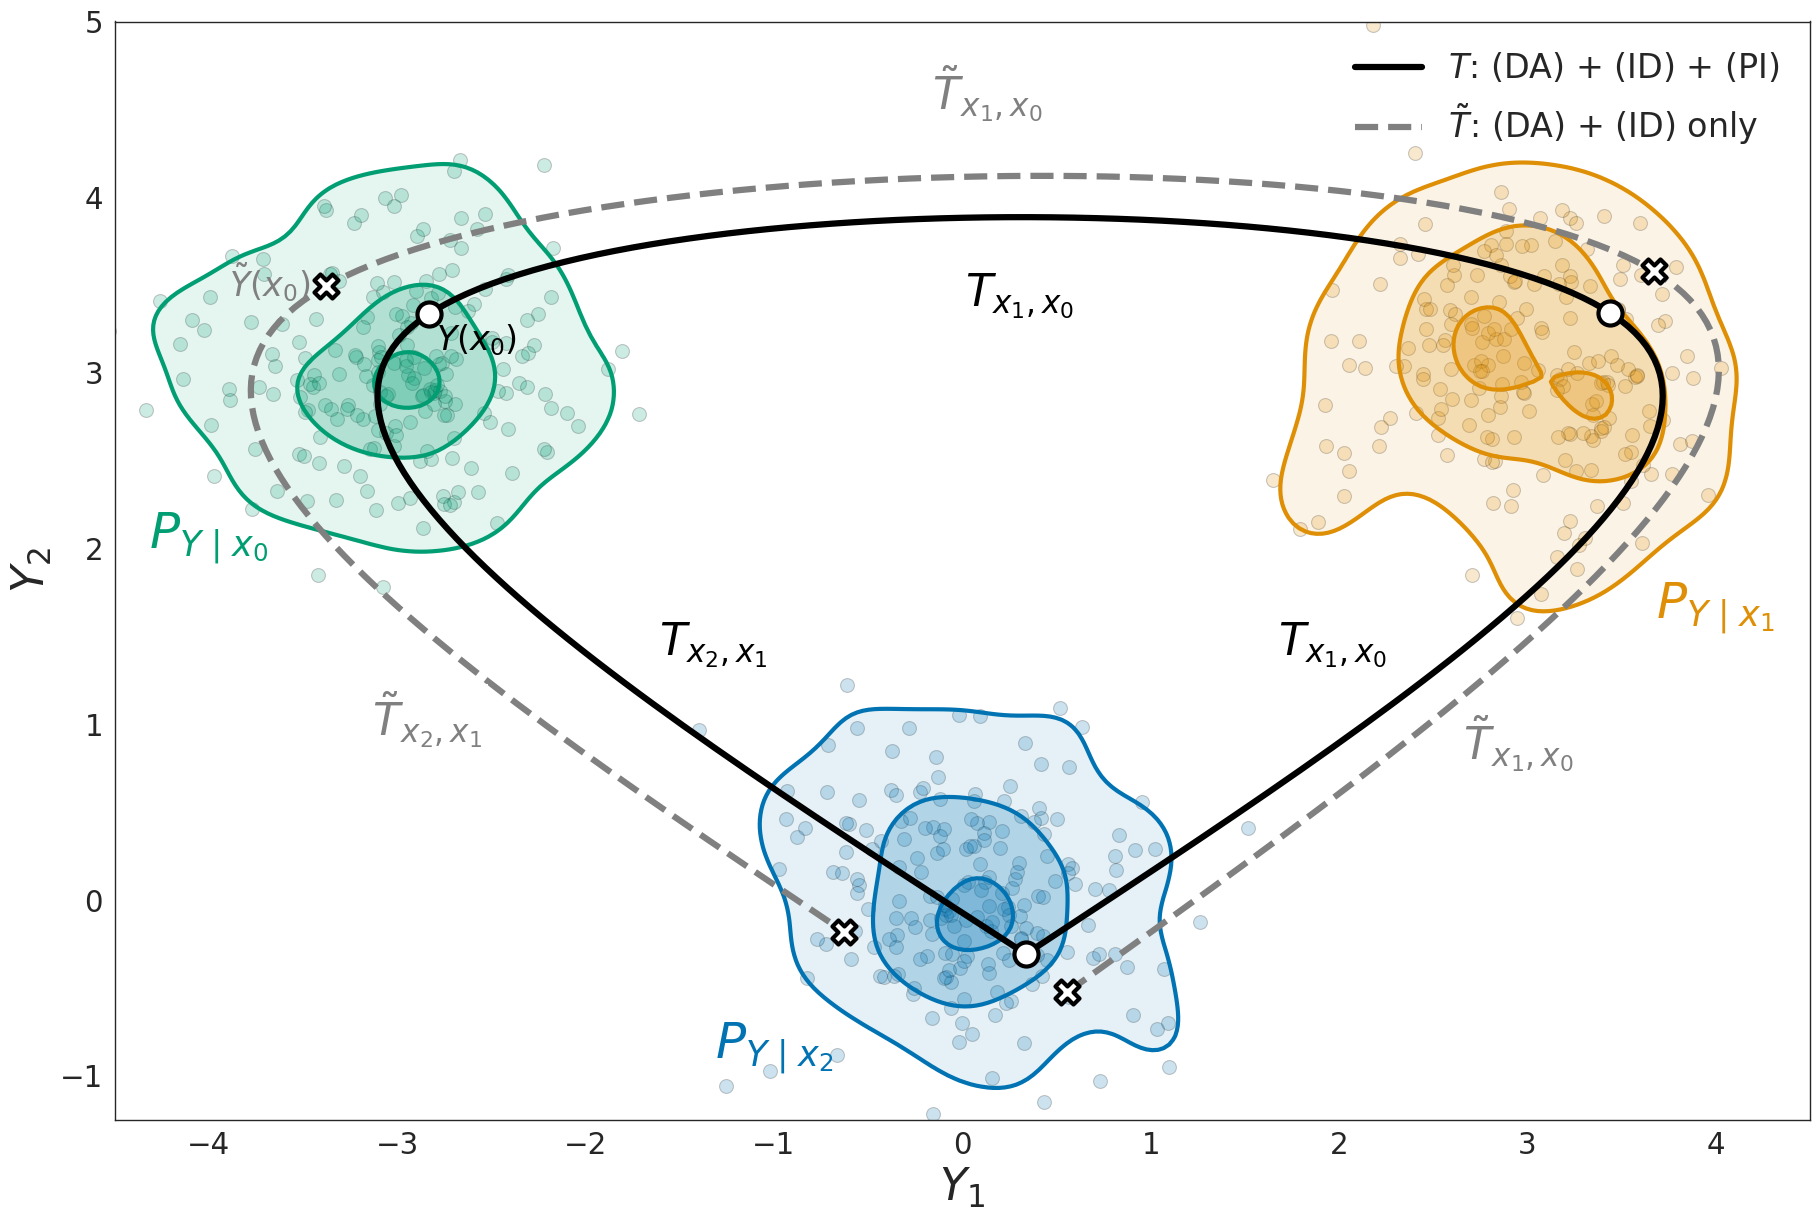

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde, norm, multivariate_normal
import logging

# Suppress font_manager messages
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Seaborn style and colour‐blind palette
sns.set_style("white")
sns.set_context("paper", font_scale=2.4)
palette = sns.color_palette("colorblind", 3)

# -------------------------------  data  ------------------------------------- #
np.random.seed(1)
n_kde = 200
mean_P0 = np.array([0, 0])
mean_P1 = np.array([3, 3])
mean_P2 = np.array([-3, 3])
samples0 = np.random.normal(loc=mean_P0, scale=0.5, size=(n_kde, 2))
samples1 = np.random.normal(loc=mean_P1, scale=0.5, size=(n_kde, 2))
samples2 = np.random.normal(loc=mean_P2, scale=0.5, size=(n_kde, 2))

# Grid for KDE
xmin, xmax, ymin, ymax = -4.5, 4.5, -2, 6
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300),
                     np.linspace(ymin, ymax, 300))
grid = np.vstack([xx.ravel(), yy.ravel()])

# Compute KDEs
Z0 = gaussian_kde(samples0.T)(grid).reshape(xx.shape)
Z1 = gaussian_kde(samples1.T)(grid).reshape(xx.shape)
Z2 = gaussian_kde(samples2.T)(grid).reshape(xx.shape)

# Contour‐thresholds (fractions of each peak)
fractions = [0.1, 0.5, 0.9]
L0 = [Z0.max()*f for f in fractions]
L1 = [Z1.max()*f for f in fractions]
L2 = [Z2.max()*f for f in fractions]

# figure
fig, ax = plt.subplots(figsize=(18, 12))

# ----- background scatter (same style as before) -----
for samples, col in zip((samples0, samples1, samples2), palette):
    ax.scatter(samples[:,0], samples[:,1],
               c=[col], s=100, alpha=0.2,
               edgecolor='black')

# ----- progressive HDR shading & contours -----
alphas = [0.1, 0.3, 0.5]   # light→dark for outer→inner

for Z, levels, col in zip((Z0, Z1, Z2), (L0, L1, L2), palette):
    low, mid, high = levels
    # outer band (10%→50%)
    ax.contourf(xx, yy, Z,
                levels=[low, mid],
                colors=[col], alpha=alphas[0],
                antialiased=True)
    # middle band (50%→90%)
    ax.contourf(xx, yy, Z,
                levels=[mid, high],
                colors=[col], alpha=alphas[1],
                antialiased=True)
    # inner band (90%→100%)
    ax.contourf(xx, yy, Z,
                levels=[high, Z.max()],
                colors=[col], alpha=alphas[2],
                antialiased=True)
    # solid outlines at thresholds
    ax.contour(xx, yy, Z,
               levels=[low, mid, high],
               colors=[col],
               linestyles='solid',
               linewidths=3)

# Sample trajectory points
scale = 0.3
P0       = np.random.normal(loc=mean_P0 + np.array([+0.5,-0.5]), scale=scale, size=(1, 2))
P0_inc   = np.random.normal(loc=mean_P0 + np.array([0.5,-0.5]),    scale=scale, size=(1, 2))
P1_cons  = np.random.normal(loc=mean_P1 + np.array([0.5,0]),       scale=scale, size=(1, 2))
P2_cons  = np.random.normal(loc=mean_P2 + np.array([-0.5,0.5]),    scale=scale, size=(1, 2))
P1_inc   = np.random.normal(loc=mean_P1 + np.array([0.5,0]),       scale=scale, size=(1, 2))
P2_inc   = np.random.normal(loc=mean_P2 + np.array([-0.7,0.7]),    scale=scale, size=(1, 2))
P0_alt   = np.random.normal(loc=mean_P0 + np.array([-0.5,-0.0]),   scale=scale, size=(1, 2))

# Time knots and parameter
t_knots = np.array([0, 1/3, 2/3, 1])
t       = np.linspace(0, 1, 200)

# Consistent loop: P0 -> P1_cons -> P2_cons -> P0 (linewidth doubled 2.5→5)
knots_c = np.vstack([P0[0], P1_cons[0], P2_cons[0], P0[0]])
cs_xc   = CubicSpline(t_knots, knots_c[:,0], bc_type='natural')
cs_yc   = CubicSpline(t_knots, knots_c[:,1], bc_type='natural')
xc, yc  = cs_xc(t), cs_yc(t)
ax.plot(xc, yc, color='black', lw=4.5, label=r'$T$: (DA) + (ID) + (PI)', ls = "-")
ax.scatter([P0[0,0], P1_cons[0,0], P2_cons[0,0]],
           [P0[0,1], P1_cons[0,1], P2_cons[0,1]],
           marker='o', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)

# Inconsistent loop: P0_inc -> P1_inc -> P2_inc -> P0_alt (linewidth doubled 2.5→5)
knots_i = np.vstack([P0_inc[0], P1_inc[0], P2_inc[0], P0_alt[0]])
cs_xi   = CubicSpline(t_knots, knots_i[:,0], bc_type='natural')
cs_yi   = CubicSpline(t_knots, knots_i[:,1], bc_type='natural')
xi, yi  = cs_xi(t), cs_yi(t)
ax.plot(xi, yi, color="grey", ls='--', lw=4.5, label=r'$\tilde T$: (DA) + (ID) only')
ax.scatter([P0_inc[0,0], P1_inc[0,0], P2_inc[0,0], P0_alt[0,0]],
           [P0_inc[0,1], P1_inc[0,1], P2_inc[0,1], P0_alt[0,1]],
           marker='X', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)

# Label each distribution (fontsize doubled 18→36)
ax.text(mean_P0[0]-1.0, mean_P0[1]-0.9, r'$P_{Y\mid x_2}$',
        color=palette[0], ha='center', fontsize=36)
ax.text(mean_P1[0]+1.0, mean_P1[1]-1.4, r'$P_{Y\mid x_1}$',
        color=palette[1], ha='center', fontsize=36)
ax.text(mean_P2[0]-1.0, mean_P2[1]-1.0, r'$P_{Y\mid x_0}$',
        color=palette[2], ha='center', fontsize=36)

pairs_cons = [(P0, P1_cons, r'$T_{x_1,x_0}$'),
             (P1_cons, P2_cons, r'$T_{x_1,x_0}$'),
             (P2_cons, P0, r'$T_{x_2,x_1}$')]
offset = -0.1
for start, end, label in pairs_cons:
    # midpoint of the segment
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2

    # direction
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]

    # perpendicular unit vector
    perp = np.array([-dy, dx])
    perp = perp / np.linalg.norm(perp)

    # shift midpoint outward
    mid_x = mid_x + perp[0] * offset
    mid_y = mid_y + perp[1] * offset
    ax.text(mid_x, mid_y, label, fontsize=32, color='black',
            ha='center', va='center', backgroundcolor='white')

offset = -1.05
pairs_inc = [(P0_inc, P1_inc, r'$\tilde T_{x_1,x_0}$'),
             (P1_inc, P2_inc, r'$\tilde T_{x_1,x_0}$'),
             (P2_inc, P0_alt, r'$\tilde T_{x_2,x_1}$')]
for start, end, label in pairs_inc:
    # midpoint of the segment
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2

    # direction
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]

    # perpendicular unit vector
    perp = np.array([-dy, dx])
    perp = perp / np.linalg.norm(perp)

    # shift midpoint outward
    mid_x = mid_x + perp[0] * offset
    mid_y = mid_y + perp[1] * offset
    ax.text(mid_x, mid_y, label, fontsize=32, color='grey',
            ha='center', va='center', backgroundcolor='white')

ax.text(P2_cons[:,0]+0.25, P2_cons[:,1]-0.15, r"$Y(x_0)$", fontsize=24, color='black',
            ha='center', va='center')
ax.text(P2_inc[:,0]-0.3, P2_inc[:,1]+0.025, r"$\tilde Y(x_0)$", fontsize=24, color='grey',
            ha='center', va='center')

# Final styling
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin+0.75, ymax-1)
ax.set_xlabel(r"$Y_1$", fontsize = 32)
ax.set_ylabel(r"$Y_2$", fontsize = 32)
ax.legend(loc='upper right', frameon=False, fontsize=24)
plt.tight_layout(pad=0)
plt.savefig("CPIproperty.png", bbox_inches = "tight")
plt.show()

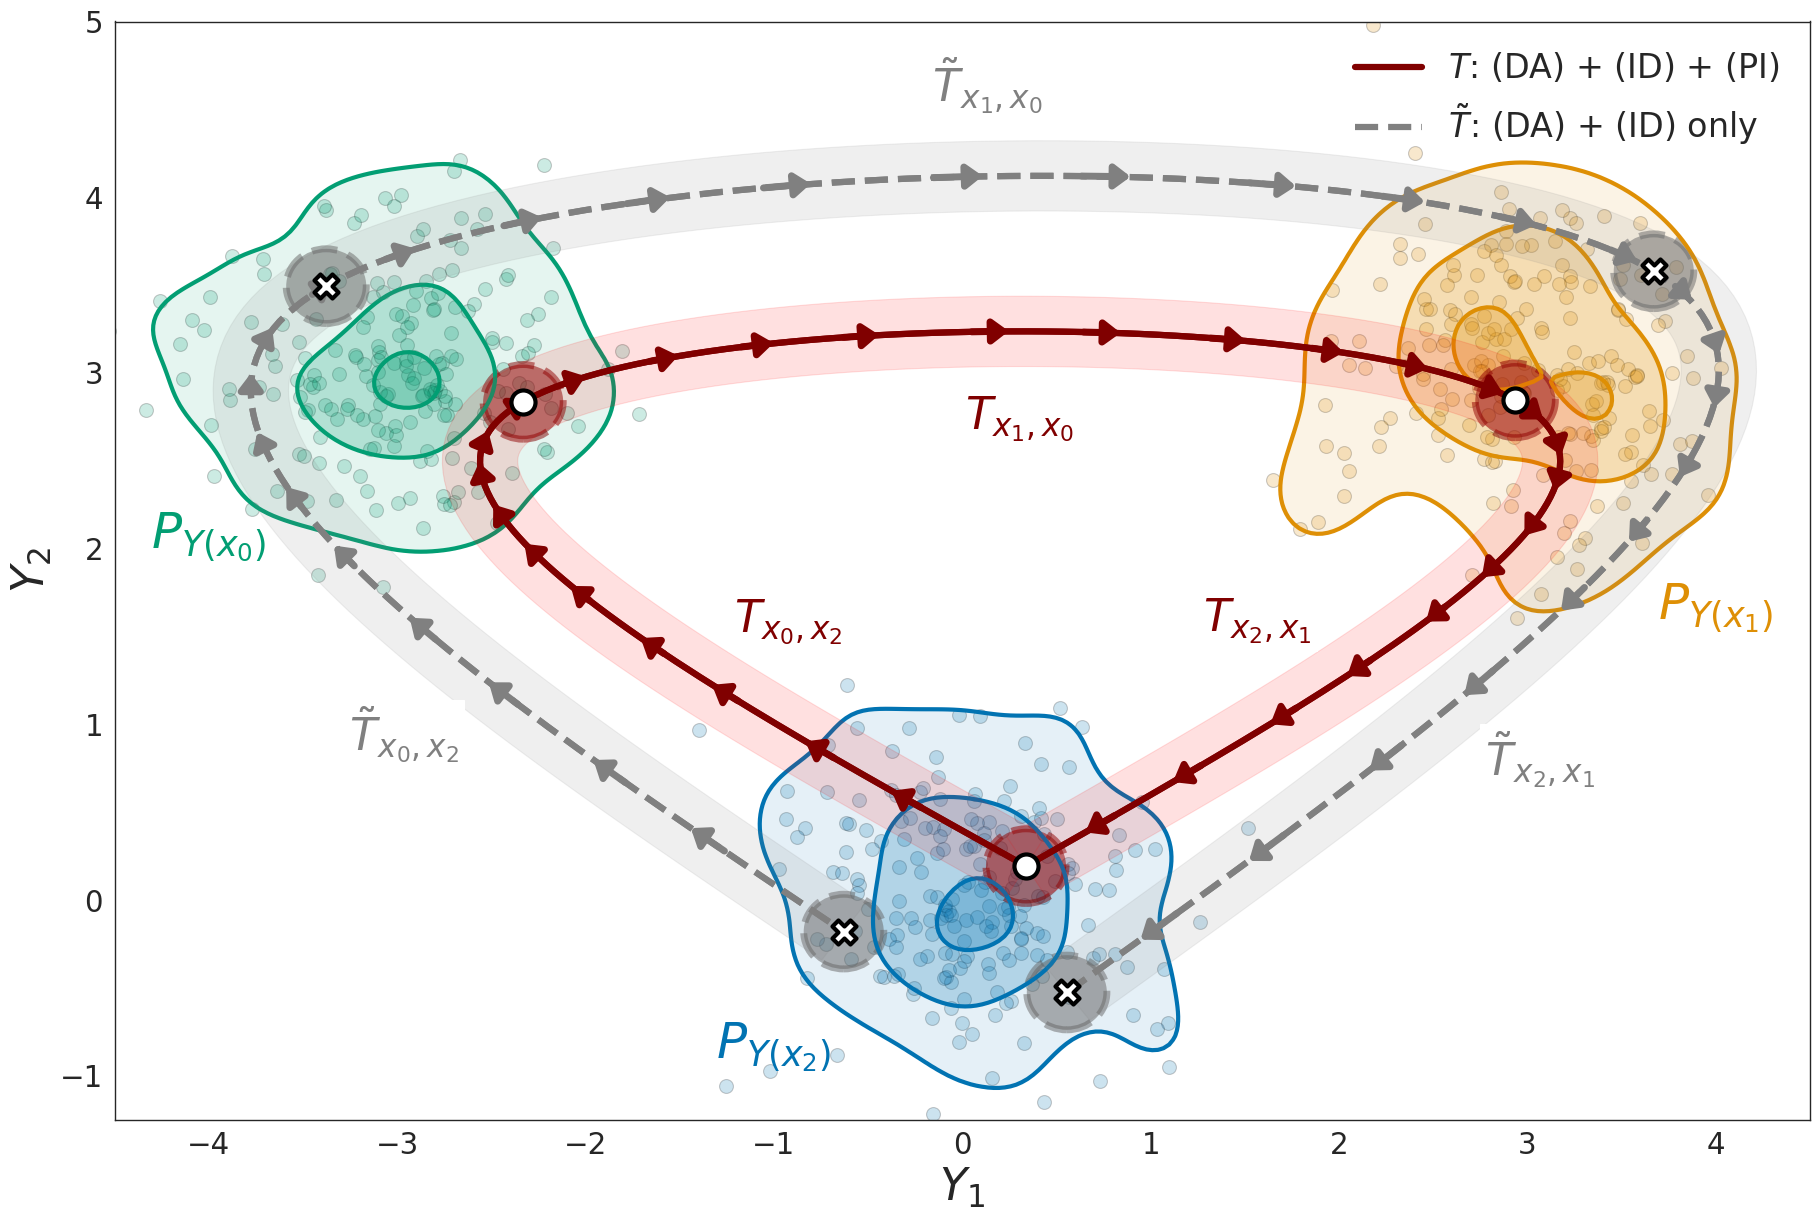

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde, norm, multivariate_normal
import logging

# Suppress font_manager messages
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Seaborn style and colour‐blind palette
sns.set_style("white")
sns.set_context("paper", font_scale=2.4)
palette = sns.color_palette("colorblind", 3)

# -------------------------------  data  ------------------------------------- #
np.random.seed(1)
n_kde = 200
mean_P0 = np.array([0, 0])
mean_P1 = np.array([3, 3])
mean_P2 = np.array([-3, 3])
samples0 = np.random.normal(loc=mean_P0, scale=0.5, size=(n_kde, 2))
samples1 = np.random.normal(loc=mean_P1, scale=0.5, size=(n_kde, 2))
samples2 = np.random.normal(loc=mean_P2, scale=0.5, size=(n_kde, 2))

# Grid for KDE
xmin, xmax, ymin, ymax = -4.5, 4.5, -2, 6
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300),
                     np.linspace(ymin, ymax, 300))
grid = np.vstack([xx.ravel(), yy.ravel()])

# Compute KDEs
Z0 = gaussian_kde(samples0.T)(grid).reshape(xx.shape)
Z1 = gaussian_kde(samples1.T)(grid).reshape(xx.shape)
Z2 = gaussian_kde(samples2.T)(grid).reshape(xx.shape)

# Contour‐thresholds (fractions of each peak)
fractions = [0.1, 0.5, 0.9]
L0 = [Z0.max()*f for f in fractions]
L1 = [Z1.max()*f for f in fractions]
L2 = [Z2.max()*f for f in fractions]

# ---------------------------- helper: tube polygon -------------------------- #
def tube_polygon(x, y, width):
    """Return polygon (px, py) for a tube of half-width `width` around curve (x,y)."""
    dx = np.gradient(x); dy = np.gradient(y)
    s = np.hypot(dx, dy)
    s[s == 0] = 1.0
    nx, ny = -dy / s, dx / s  # unit normals
    xu, yu = x + width * nx, y + width * ny
    xl, yl = x - width * nx, y - width * ny
    px = np.concatenate([xu, xl[::-1]])
    py = np.concatenate([yu, yl[::-1]])
    return px, py

# --------------------------------- figure ----------------------------------- #
fig, ax = plt.subplots(figsize=(18, 12))

# ----- background scatter -----
for samples, col in zip((samples0, samples1, samples2), palette):
    ax.scatter(samples[:,0], samples[:,1],
               c=[col], s=100, alpha=0.2,
               edgecolor='black')

# ----- progressive HDR shading & contours -----
alphas = [0.1, 0.3, 0.5]   # light→dark for outer→inner
for Z, levels, col in zip((Z0, Z1, Z2), (L0, L1, L2), palette):
    low, mid, high = levels
    ax.contourf(xx, yy, Z, levels=[low, mid], colors=[col], alpha=alphas[0], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[mid, high], colors=[col], alpha=alphas[1], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[high, Z.max()], colors=[col], alpha=alphas[2], antialiased=True)
    ax.contour(xx, yy, Z, levels=[low, mid, high], colors=[col], linestyles='solid', linewidths=3)

# Sample trajectory points (unchanged)
scale = 0.3
P0       = np.random.normal(loc=mean_P0 + np.array([+0.5,0]), scale=scale, size=(1, 2))
P0_inc   = np.random.normal(loc=mean_P0 + np.array([0.5,-0.5]),  scale=scale, size=(1, 2))
P1_cons  = np.random.normal(loc=mean_P1 + np.array([0.0,-0.5]),     scale=scale, size=(1, 2))
P2_cons  = np.random.normal(loc=mean_P2 + np.array([0,0]),  scale=scale, size=(1, 2))
P1_inc   = np.random.normal(loc=mean_P1 + np.array([0.5,0]),     scale=scale, size=(1, 2))
P2_inc   = np.random.normal(loc=mean_P2 + np.array([-0.7,0.7]),  scale=scale, size=(1, 2))
P0_alt   = np.random.normal(loc=mean_P0 + np.array([-0.5,-0.0]), scale=scale, size=(1, 2))

# Time knots and parameter
t_knots = np.array([0, 1/3, 2/3, 1])
t       = np.linspace(0, 1, 200)

# Consistent loop: P0 -> P1_cons -> P2_cons -> P0
knots_c = np.vstack([P0[0], P1_cons[0], P2_cons[0], P0[0]])
cs_xc   = CubicSpline(t_knots, knots_c[:,0], bc_type='natural')
cs_yc   = CubicSpline(t_knots, knots_c[:,1], bc_type='natural')
xc, yc  = cs_xc(t), cs_yc(t)

# Inconsistent loop: P0_inc -> P1_inc -> P2_inc -> P0_alt
knots_i = np.vstack([P0_inc[0], P1_inc[0], P2_inc[0], P0_alt[0]])
cs_xi   = CubicSpline(t_knots, knots_i[:,0], bc_type='natural')
cs_yi   = CubicSpline(t_knots, knots_i[:,1], bc_type='natural')
xi, yi  = cs_xi(t), cs_yi(t)

# ----------------------------- shaded trajectory tubes ---------------------- #
tube_w = 0.2  # visual half-width; adjust as desired (does not change the curve)

# Tube for the consistent (black) path
px, py = tube_polygon(xc, yc, tube_w)
ax.fill(px, py, color="red", alpha=0.12, zorder=2)

# Tube for the inconsistent (grey dashed) path
px, py = tube_polygon(xi, yi, tube_w)
ax.fill(px, py, color="grey", alpha=0.12, zorder=2)

# Draw the original centerlines on top
ax.plot(xc, yc, color='maroon', lw=4.5, label=r'$T$: (DA) + (ID) + (PI)', ls="-", zorder=3)
ax.plot(xi, yi, color="grey", ls='--', lw=4.5, label=r'$\tilde T$: (DA) + (ID) only', zorder=3)

# Markers at waypoints (unchanged)
ax.scatter([P0[0,0], P1_cons[0,0], P2_cons[0,0]],
           [P0[0,1], P1_cons[0,1], P2_cons[0,1]],
           marker='o', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)
ax.scatter([P0_inc[0,0], P1_inc[0,0], P2_inc[0,0], P0_alt[0,0]],
           [P0_inc[0,1], P1_inc[0,1], P2_inc[0,1], P0_alt[0,1]],
           marker='X', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)

# Labels for each distribution
ax.text(mean_P0[0]-1.0, mean_P0[1]-0.9, r'$P_{Y(x_2)}$',
        color=palette[0], ha='center', fontsize=36)
ax.text(mean_P1[0]+1.0, mean_P1[1]-1.4, r'$P_{Y(x_1)}$',
        color=palette[1], ha='center', fontsize=36)
ax.text(mean_P2[0]-1.0, mean_P2[1]-1.0, r'$P_{Y(x_0)}$',
        color=palette[2], ha='center', fontsize=36)

# Edge labels (unchanged)
pairs_cons = [(P0, P1_cons, r'$T_{x_2,x_1}$'),
              (P1_cons, P2_cons, r'$T_{x_1,x_0}$'),
              (P2_cons, P0, r'$T_{x_0,x_2}$')]
offset = 0.1

for start, end, label in pairs_cons:
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]
    perp = np.array([-dy, dx]); perp = perp / np.linalg.norm(perp)
    mid_x += perp[0] * offset; mid_y += perp[1] * offset
    ax.text(mid_x, mid_y, label, fontsize=32, color='maroon',
            ha='center', va='center', backgroundcolor='white')

pairs_inc = [(P0_inc, P1_inc, r'$\tilde T_{x_2,x_1}$'),
             (P1_inc, P2_inc, r'$\tilde T_{x_1,x_0}$'),
             (P2_inc, P0_alt, r'$\tilde T_{x_0,x_2}$')]
offset = -1.1
t = 0 
for start, end, label in pairs_inc:
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]
    perp = np.array([-dy, dx]); perp = perp / np.linalg.norm(perp)
    if t == 1:
        off = offset
    else:
        off = -1.2
    mid_x += perp[0] * off; mid_y += perp[1] * off
    ax.text(mid_x, mid_y, label, fontsize=32, color='grey',
            ha='center', va='center', backgroundcolor='white')
    t += 1

# Point labels
#ax.text(P2_cons[:,0]+0.25, P2_cons[:,1]-0.15, r"$y(x_0)$", fontsize=30, color='maroon',
#        ha='center', va='center')
#ax.text(P2_inc[:,0]-0.35, P2_inc[:,1]+0.025, r"$\tilde y(x_0)$", fontsize=30, color='grey',
#        ha='center', va='center')
#ax.text(P0[:,0], P0[:,1]+0.35, r"$y(x_2)$", fontsize=30, color='maroon',
#        ha='center', va='center')
#ax.text(P0_inc[:,0]-0.25, P0_inc[:,1]-0.2, r"$\tilde y(x_2)$", fontsize=30, color='gray',
#        ha='center', va='center')
#ax.text(P0_alt[:,0]+0.05, P0_alt[:,1]-0.2, r"$\tilde y(x_2)$", fontsize=30, color='gray',
#        ha='center', va='center')
#ax.text(P1_cons[:,0]-0.25, P1_cons[:,1]-0.2, r"$ y(x_1)$", fontsize=30, color='maroon',
#        ha='center', va='center')
#ax.text(P1_inc[:,0]+0.2, P1_inc[:,1]+0.2, r"$\tilde y(x_1)$", fontsize=30, color='gray',
#        ha='center', va='center')

# --------------------- shaded regions around each waypoint ------------------- #
def add_region(center, width, height, edge_color, face_color, ax, angle=0, alpha=0.5, lw=5):
    """Add an ellipse region (positive-measure neighborhood) with dashed edge."""
    e = patches.Ellipse(
        (center[0,0], center[0,1]),
        width=width, height=height, angle=angle,
        facecolor=face_color, edgecolor=edge_color,
        linewidth=lw, linestyle= "dashed",  # dashed boundary
        alpha=alpha
    )
    ax.add_patch(e)

# Consistent path regions (maroon)
W, H = 0.425, 0.425
maroon = (128/255, 0, 0)
add_region(P0,      W, H, edge_color=maroon, face_color=maroon, ax=ax)
add_region(P1_cons, W, H, edge_color=maroon, face_color=maroon, ax=ax)
add_region(P2_cons, W, H, edge_color=maroon, face_color=maroon, ax=ax)

# Inconsistent path regions (gray)
gray = (0.4, 0.4, 0.4)
add_region(P0_inc,  W, H, edge_color=gray, face_color=gray, ax=ax)
add_region(P1_inc,  W, H, edge_color=gray, face_color=gray, ax=ax)
add_region(P2_inc,  W, H, edge_color=gray, face_color=gray, ax=ax)
add_region(P0_alt,  W, H, edge_color=gray, face_color=gray, ax=ax)

def add_arrows_along_line(ax, x, y, n_arrows=3, color="k", lw=3, size=20, clockwise=True):
    """Add arrows along a parametric curve (x,y). If clockwise=True, flip orientation."""
    s = np.linspace(0, len(x)-1, n_arrows+2, dtype=int)[1:-1]  # skip first/last
    for idx in s:
        dx = x[idx+1] - x[idx-1]
        dy = y[idx+1] - y[idx-1]
        if clockwise:
            dx, dy = -dx, -dy  # flip direction
        ax.annotate("",
            xy=(x[idx]+dx, y[idx]+dy),
            xytext=(x[idx], y[idx]),
            arrowprops=dict(
                arrowstyle="-|>,head_width=0.3,head_length=0.4",
                color=color, lw=lw,
                shrinkA=0, shrinkB=0
            ))

# Draw the original centerlines on top
ax.plot(xc, yc, color='maroon', lw=4.5, ls="-", zorder=3)
ax.plot(xi, yi, color="grey", lw=4.5, ls="--", zorder=3)

# Add arrows showing orientation (clockwise)
add_arrows_along_line(ax, xc, yc, n_arrows=30, color="maroon", lw=5)
add_arrows_along_line(ax, xi, yi, n_arrows=30, color="grey", lw=5)

# Final styling
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin+0.75, ymax-1)
ax.set_xlabel(r"$Y_1$", fontsize=32)
ax.set_ylabel(r"$Y_2$", fontsize=32)
ax.legend(loc='upper right', frameon=False, fontsize=24)
plt.tight_layout(pad=0)
plt.savefig("CPIproperty_tubes.png", bbox_inches="tight", dpi=300)
plt.show()

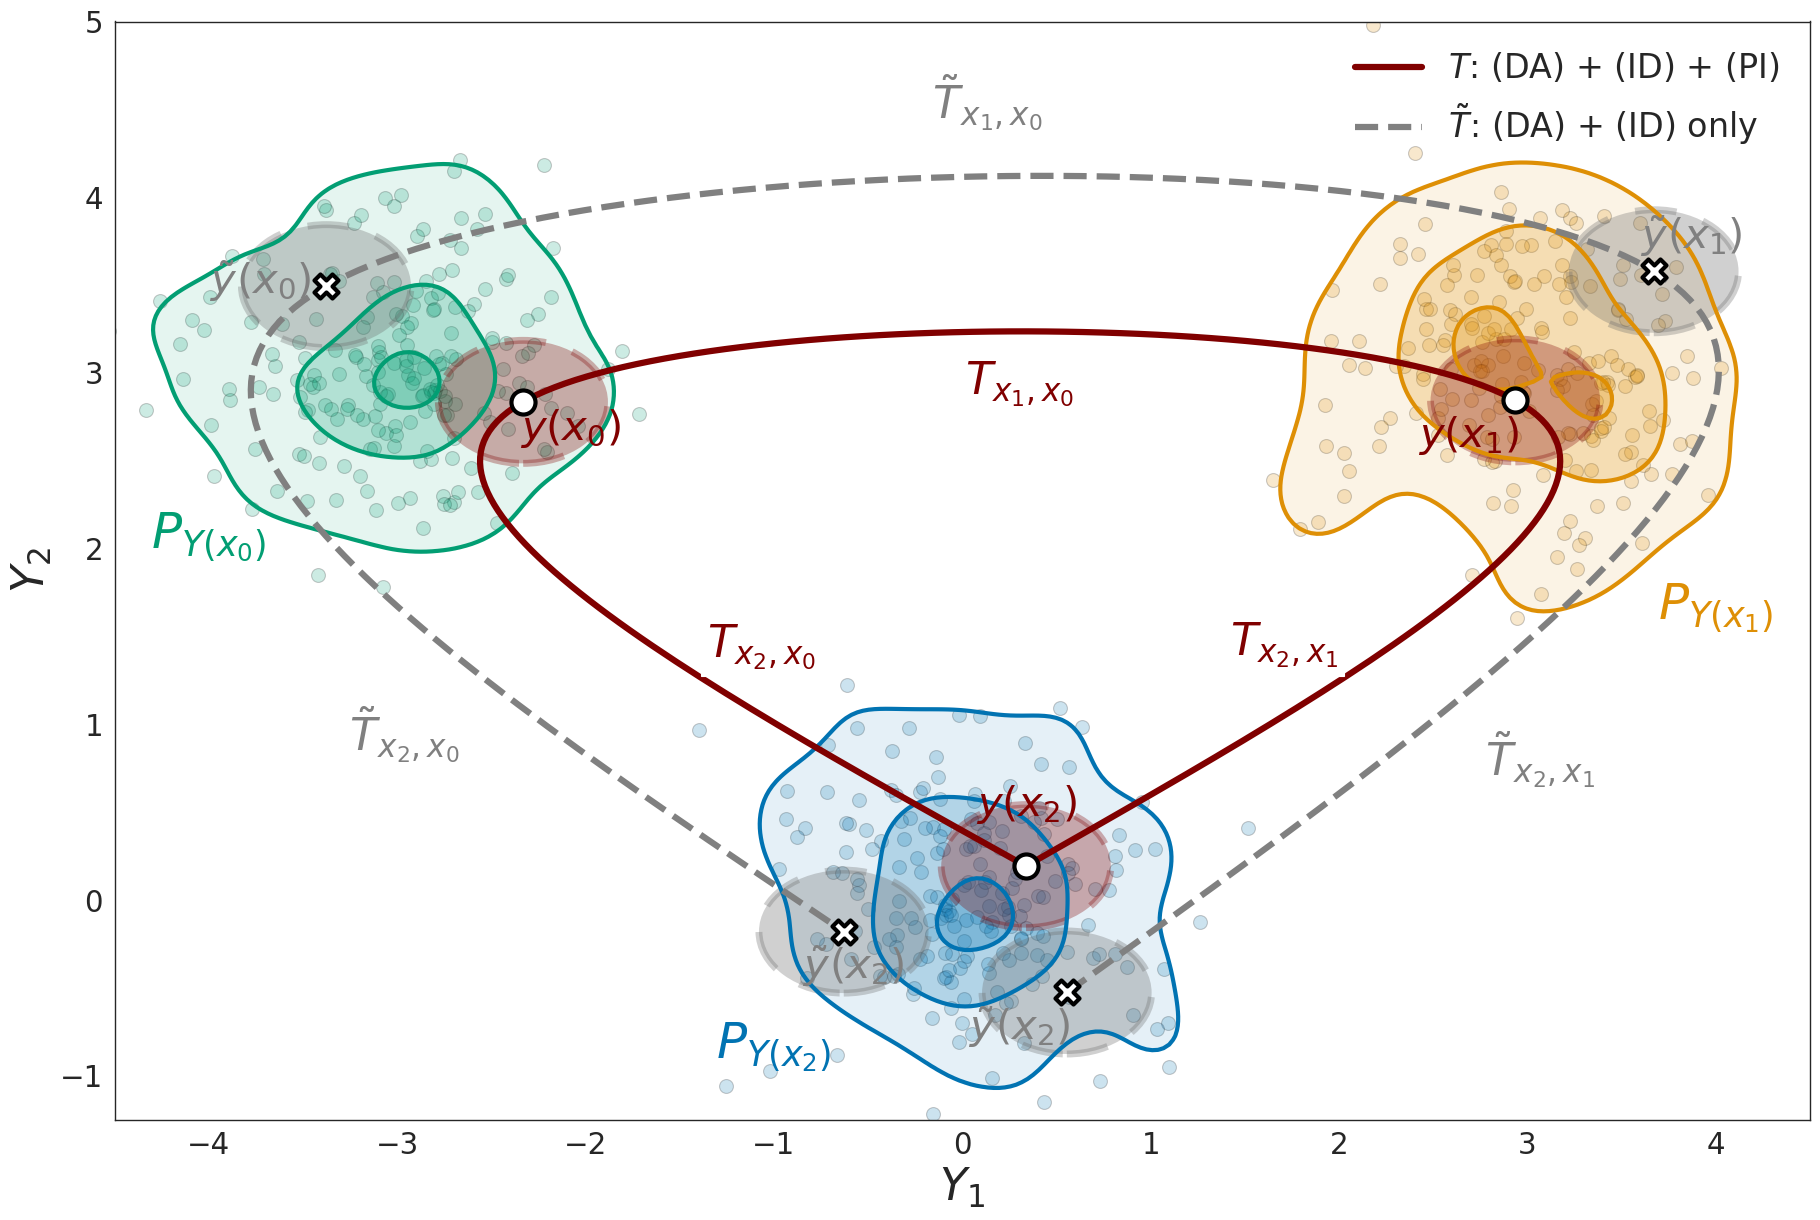

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde
import matplotlib.patches as patches
import logging

# Suppress font_manager messages
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Seaborn style and colour‐blind palette
sns.set_style("white")
sns.set_context("paper", font_scale=2.4)
palette = sns.color_palette("colorblind", 3)

# -------------------------------  data  ------------------------------------- #
np.random.seed(1)
n_kde = 200
mean_P0 = np.array([0, 0])
mean_P1 = np.array([3, 3])
mean_P2 = np.array([-3, 3])
samples0 = np.random.normal(loc=mean_P0, scale=0.5, size=(n_kde, 2))
samples1 = np.random.normal(loc=mean_P1, scale=0.5, size=(n_kde, 2))
samples2 = np.random.normal(loc=mean_P2, scale=0.5, size=(n_kde, 2))

# Grid for KDE
xmin, xmax, ymin, ymax = -4.5, 4.5, -2, 6
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300),
                     np.linspace(ymin, ymax, 300))
grid = np.vstack([xx.ravel(), yy.ravel()])

# Compute KDEs
Z0 = gaussian_kde(samples0.T)(grid).reshape(xx.shape)
Z1 = gaussian_kde(samples1.T)(grid).reshape(xx.shape)
Z2 = gaussian_kde(samples2.T)(grid).reshape(xx.shape)

# Contour‐thresholds (fractions of each peak)
fractions = [0.1, 0.5, 0.9]
L0 = [Z0.max()*f for f in fractions]
L1 = [Z1.max()*f for f in fractions]
L2 = [Z2.max()*f for f in fractions]

# --------------------------------- figure ----------------------------------- #
fig, ax = plt.subplots(figsize=(18, 12))

# ----- background scatter -----
for samples, col in zip((samples0, samples1, samples2), palette):
    ax.scatter(samples[:,0], samples[:,1],
               c=[col], s=100, alpha=0.2,
               edgecolor='black')

# ----- progressive HDR shading & contours -----
alphas = [0.1, 0.3, 0.5]   # light→dark for outer→inner
for Z, levels, col in zip((Z0, Z1, Z2), (L0, L1, L2), palette):
    low, mid, high = levels
    ax.contourf(xx, yy, Z, levels=[low, mid], colors=[col], alpha=alphas[0], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[mid, high], colors=[col], alpha=alphas[1], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[high, Z.max()], colors=[col], alpha=alphas[2], antialiased=True)
    ax.contour(xx, yy, Z, levels=[low, mid, high], colors=[col], linestyles='solid', linewidths=3)

# Sample trajectory points (unchanged)
scale = 0.3
P0       = np.random.normal(loc=mean_P0 + np.array([+0.5,0]), scale=scale, size=(1, 2))
P0_inc   = np.random.normal(loc=mean_P0 + np.array([0.5,-0.5]),  scale=scale, size=(1, 2))
P1_cons  = np.random.normal(loc=mean_P1 + np.array([0.0,-0.5]),     scale=scale, size=(1, 2))
P2_cons  = np.random.normal(loc=mean_P2 + np.array([0,0]),  scale=scale, size=(1, 2))
P1_inc   = np.random.normal(loc=mean_P1 + np.array([0.5,0]),     scale=scale, size=(1, 2))
P2_inc   = np.random.normal(loc=mean_P2 + np.array([-0.7,0.7]),  scale=scale, size=(1, 2))
P0_alt   = np.random.normal(loc=mean_P0 + np.array([-0.5,-0.0]), scale=scale, size=(1, 2))

# Time knots and parameter
t_knots = np.array([0, 1/3, 2/3, 1])
t       = np.linspace(0, 1, 200)

# Consistent loop: P0 -> P1_cons -> P2_cons -> P0
knots_c = np.vstack([P0[0], P1_cons[0], P2_cons[0], P0[0]])
cs_xc   = CubicSpline(t_knots, knots_c[:,0], bc_type='natural')
cs_yc   = CubicSpline(t_knots, knots_c[:,1], bc_type='natural')
xc, yc  = cs_xc(t), cs_yc(t)

# Inconsistent loop: P0_inc -> P1_inc -> P2_inc -> P0_alt
knots_i = np.vstack([P0_inc[0], P1_inc[0], P2_inc[0], P0_alt[0]])
cs_xi   = CubicSpline(t_knots, knots_i[:,0], bc_type='natural')
cs_yi   = CubicSpline(t_knots, knots_i[:,1], bc_type='natural')
xi, yi  = cs_xi(t), cs_yi(t)

# --------------------- shaded regions around each waypoint ------------------- #
def add_region(center, width, height, edge_color, face_color, ax, angle=0, alpha=0.3, lw=5):
    """Add an ellipse region (positive-measure neighborhood) with dashed edge."""
    e = patches.Ellipse(
        (center[0,0], center[0,1]),
        width=width, height=height, angle=angle,
        facecolor=face_color, edgecolor=edge_color,
        linewidth=lw, linestyle=(0, (6, 4)),  # dashed boundary
        alpha=alpha
    )
    ax.add_patch(e)

# region size (in data units); tweak to taste
W, H = 0.9, 0.7

# Consistent path regions (maroon)
maroon = (128/255, 0, 0)
add_region(P0,      W, H, edge_color=maroon, face_color=maroon, ax=ax)
add_region(P1_cons, W, H, edge_color=maroon, face_color=maroon, ax=ax)
add_region(P2_cons, W, H, edge_color=maroon, face_color=maroon, ax=ax)

# Inconsistent path regions (gray)
gray = (0.4, 0.4, 0.4)
add_region(P0_inc,  W, H, edge_color=gray, face_color=gray, ax=ax)
add_region(P1_inc,  W, H, edge_color=gray, face_color=gray, ax=ax)
add_region(P2_inc,  W, H, edge_color=gray, face_color=gray, ax=ax)
add_region(P0_alt,  W, H, edge_color=gray, face_color=gray, ax=ax)

# ------------------------ centerlines and markers on top --------------------- #
ax.plot(xc, yc, color=maroon, lw=4.5, label=r'$T$: (DA) + (ID) + (PI)', ls="-", zorder=3)
ax.plot(xi, yi, color="grey",  ls='--', lw=4.5, label=r'$\tilde T$: (DA) + (ID) only', zorder=3)

ax.scatter([P0[0,0], P1_cons[0,0], P2_cons[0,0]],
           [P0[0,1], P1_cons[0,1], P2_cons[0,1]],
           marker='o', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)
ax.scatter([P0_inc[0,0], P1_inc[0,0], P2_inc[0,0], P0_alt[0,0]],
           [P0_inc[0,1], P1_inc[0,1], P2_inc[0,1], P0_alt[0,1]],
           marker='X', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)

# Labels for each distribution
ax.text(mean_P0[0]-1.0, mean_P0[1]-0.9, r'$P_{Y(x_2)}$',
        color=palette[0], ha='center', fontsize=36)
ax.text(mean_P1[0]+1.0, mean_P1[1]-1.4, r'$P_{Y(x_1)}$',
        color=palette[1], ha='center', fontsize=36)
ax.text(mean_P2[0]-1.0, mean_P2[1]-1.0, r'$P_{Y(x_0)}$',
        color=palette[2], ha='center', fontsize=36)

# Edge labels (kept; colors matched to paths)
pairs_cons = [(P0, P1_cons, r'$T_{x_2,x_1}$'),
              (P1_cons, P2_cons, r'$T_{x_1,x_0}$'),
              (P2_cons, P0, r'$T_{x_2,x_0}$')]
offset = -0.1
for start, end, label in pairs_cons:
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]
    perp = np.array([-dy, dx]); perp = perp / np.linalg.norm(perp)
    mid_x += perp[0] * offset; mid_y += perp[1] * offset
    ax.text(mid_x, mid_y, label, fontsize=32, color=maroon,
            ha='center', va='center', backgroundcolor='white')

pairs_inc = [(P0_inc, P1_inc, r'$\tilde T_{x_2,x_1}$'),
             (P1_inc, P2_inc, r'$\tilde T_{x_1,x_0}$'),
             (P2_inc, P0_alt, r'$\tilde T_{x_2,x_0}$')]
offset = -1.0
for i, (start, end, label) in enumerate(pairs_inc):
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]
    perp = np.array([-dy, dx]); perp = perp / np.linalg.norm(perp)
    off = offset if i == 1 else -1.2
    mid_x += perp[0] * off; mid_y += perp[1] * off
    ax.text(mid_x, mid_y, label, fontsize=32, color='grey',
            ha='center', va='center', backgroundcolor='white')

# Point labels
ax.text(P2_cons[:,0]+0.25, P2_cons[:,1]-0.15, r"$y(x_0)$", fontsize=30, color='maroon',
        ha='center', va='center')
ax.text(P2_inc[:,0]-0.35, P2_inc[:,1]+0.025, r"$\tilde y(x_0)$", fontsize=30, color='grey',
        ha='center', va='center')
ax.text(P0[:,0], P0[:,1]+0.35, r"$y(x_2)$", fontsize=30, color='maroon',
        ha='center', va='center')
ax.text(P0_inc[:,0]-0.25, P0_inc[:,1]-0.2, r"$\tilde y(x_2)$", fontsize=30, color='gray',
        ha='center', va='center')
ax.text(P0_alt[:,0]+0.05, P0_alt[:,1]-0.2, r"$\tilde y(x_2)$", fontsize=30, color='gray',
        ha='center', va='center')
ax.text(P1_cons[:,0]-0.25, P1_cons[:,1]-0.2, r"$ y(x_1)$", fontsize=30, color='maroon',
        ha='center', va='center')
ax.text(P1_inc[:,0]+0.2, P1_inc[:,1]+0.2, r"$\tilde y(x_1)$", fontsize=30, color='gray',
        ha='center', va='center')
# Final styling
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin+0.75, ymax-1)
ax.set_xlabel(r"$Y_1$", fontsize=32)
ax.set_ylabel(r"$Y_2$", fontsize=32)
ax.legend(loc='upper right', frameon=False, fontsize=24)
plt.tight_layout(pad=0)
plt.savefig("CPIproperty_tubes.png", bbox_inches="tight", dpi=300)
plt.show()

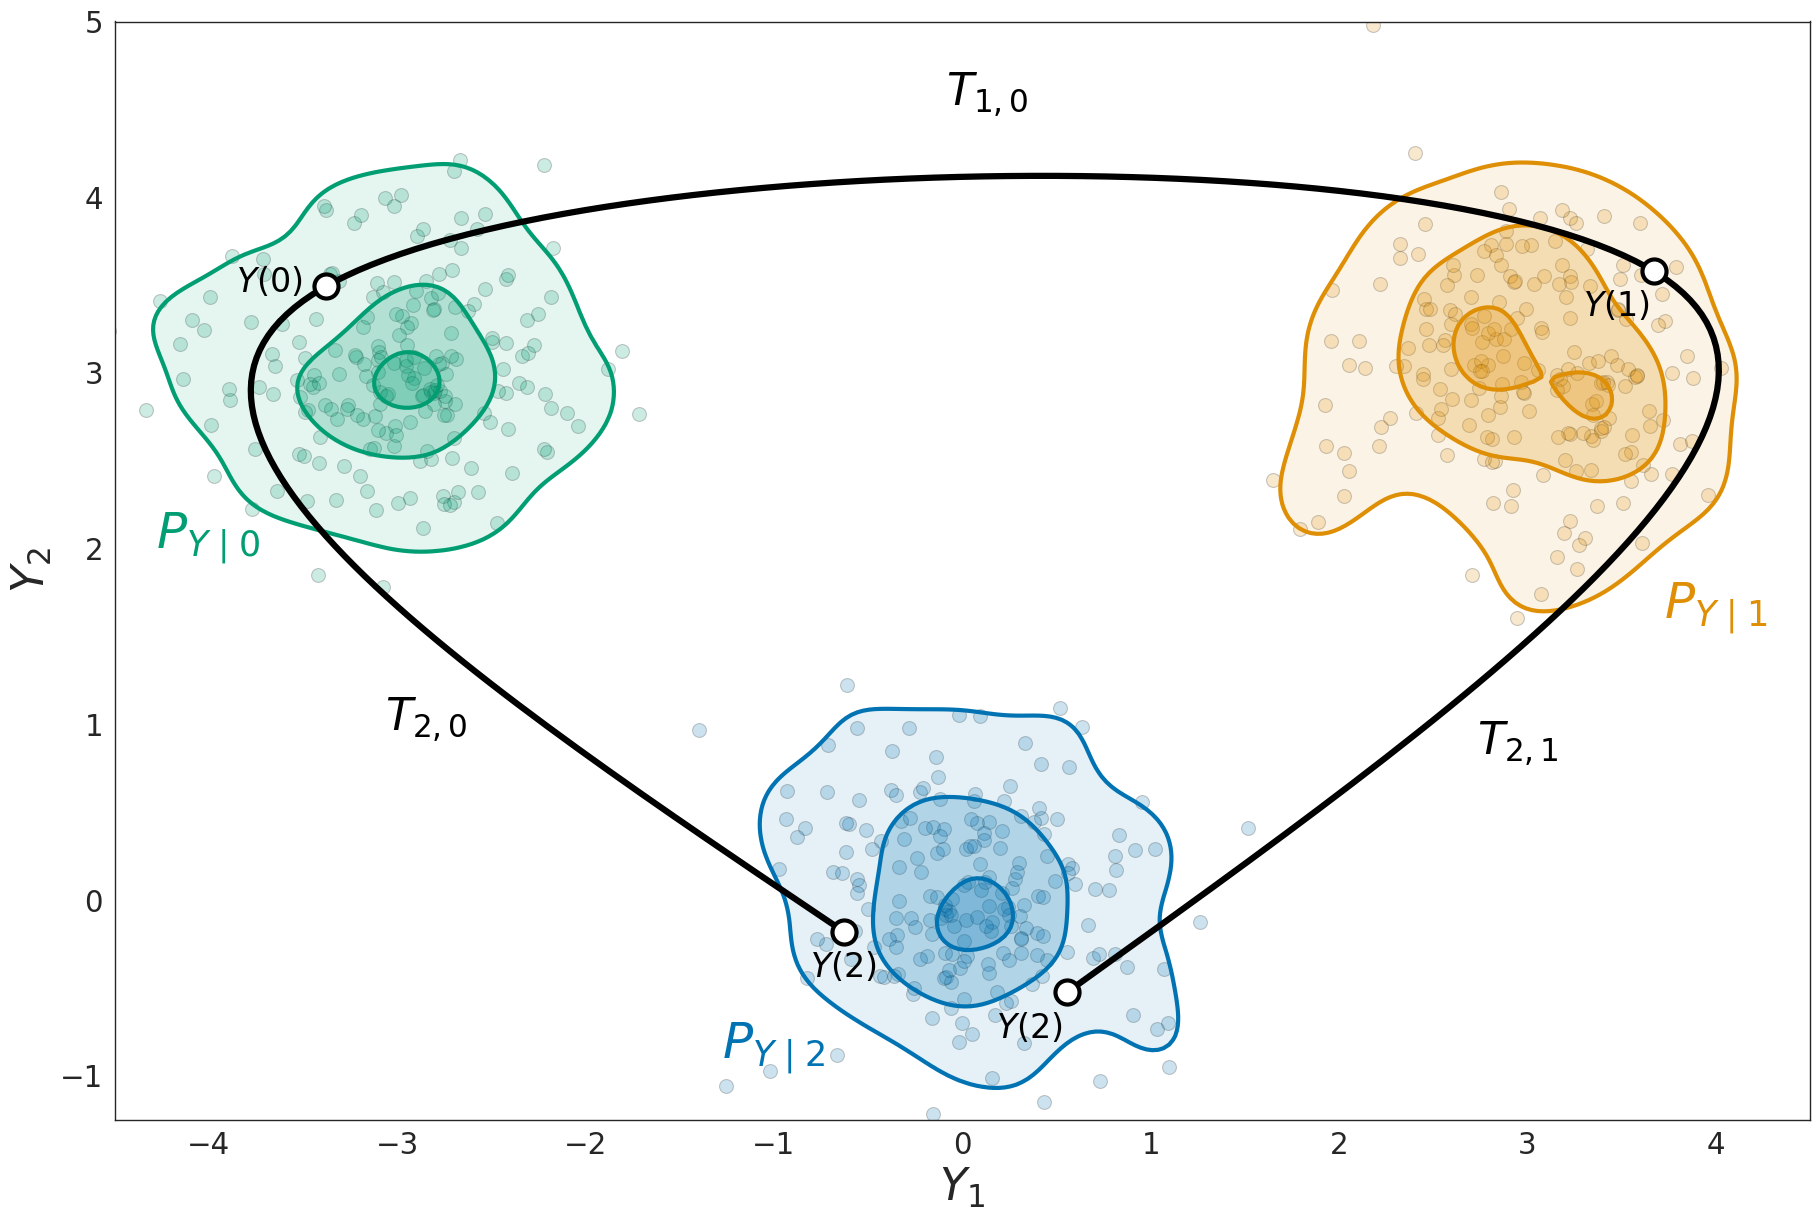

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde
import logging

# Suppress font_manager messages
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Seaborn style and colour‐blind palette
sns.set_style("white")
sns.set_context("paper", font_scale=2.4)
palette = sns.color_palette("colorblind", 3)

# -------------------------------  data  ------------------------------------- #
np.random.seed(1)
n_kde = 200
mean_P0 = np.array([0, 0])      # previously x_? -> now used for label {0,1,2} after rotation below
mean_P1 = np.array([3, 3])
mean_P2 = np.array([-3, 3])

samples0 = np.random.normal(loc=mean_P0, scale=0.5, size=(n_kde, 2))
samples1 = np.random.normal(loc=mean_P1, scale=0.5, size=(n_kde, 2))
samples2 = np.random.normal(loc=mean_P2, scale=0.5, size=(n_kde, 2))

# Grid for KDE
xmin, xmax, ymin, ymax = -4.5, 4.5, -2, 6
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300),
                     np.linspace(ymin, ymax, 300))
grid = np.vstack([xx.ravel(), yy.ravel()])

# Compute KDEs
Z0 = gaussian_kde(samples0.T)(grid).reshape(xx.shape)
Z1 = gaussian_kde(samples1.T)(grid).reshape(xx.shape)
Z2 = gaussian_kde(samples2.T)(grid).reshape(xx.shape)

# Contour‐thresholds (fractions of each peak)
fractions = [0.1, 0.5, 0.9]
L0 = [Z0.max()*f for f in fractions]
L1 = [Z1.max()*f for f in fractions]
L2 = [Z2.max()*f for f in fractions]

# figure
fig, ax = plt.subplots(figsize=(18, 12))

# ----- background scatter -----
for samples, col in zip((samples0, samples1, samples2), palette):
    ax.scatter(samples[:,0], samples[:,1],
               c=[col], s=100, alpha=0.2, edgecolor='black')

# ----- progressive HDR shading & contours -----
alphas = [0.1, 0.3, 0.5]   # light→dark for outer→inner
for Z, levels, col in zip((Z0, Z1, Z2), (L0, L1, L2), palette):
    low, mid, high = levels
    ax.contourf(xx, yy, Z, levels=[low, mid], colors=[col], alpha=alphas[0], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[mid, high], colors=[col], alpha=alphas[1], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[high, Z.max()], colors=[col], alpha=alphas[2], antialiased=True)
    ax.contour(xx, yy, Z, levels=[low, mid, high], colors=[col], linestyles='solid', linewidths=3)

# -------------------- trajectory points (use *tilde* ones) ------------------- #
scale = 0.3
P0       = np.random.normal(loc=mean_P0 + np.array([+0.5,-0.5]), scale=scale, size=(1, 2))
P0_inc   = np.random.normal(loc=mean_P0 + np.array([0.5,-0.5]),  scale=scale, size=(1, 2))
P1_cons  = np.random.normal(loc=mean_P1 + np.array([0.5,0]),     scale=scale, size=(1, 2))
P2_cons  = np.random.normal(loc=mean_P2 + np.array([-0.5,0.5]),  scale=scale, size=(1, 2))
P1_inc   = np.random.normal(loc=mean_P1 + np.array([0.5,0]),     scale=scale, size=(1, 2))
P2_inc   = np.random.normal(loc=mean_P2 + np.array([-0.7,0.7]),  scale=scale, size=(1, 2))
P0_alt   = np.random.normal(loc=mean_P0 + np.array([-0.5,-0.0]), scale=scale, size=(1, 2))

# Time knots and parameter
t_knots = np.array([0, 1/3, 2/3, 1])
t       = np.linspace(0, 1, 200)

# ---------------- single displayed trajectory ----------------
# Use the *tilde* control points but style/label it like the non-tilde T.
knots_single = np.vstack([P0_inc[0], P1_inc[0], P2_inc[0], P0_alt[0]])
cs_x   = CubicSpline(t_knots, knots_single[:,0], bc_type='natural')
cs_y   = CubicSpline(t_knots, knots_single[:,1], bc_type='natural')
x_s, y_s  = cs_x(t), cs_y(t)

# Plot the single trajectory (solid black line, circle markers)
ax.plot(x_s, y_s, color='black', lw=4.5, ls='-')
ax.scatter([knots_single[0,0], knots_single[1,0], knots_single[2,0], knots_single[3,0]],
           [knots_single[0,1], knots_single[1,1], knots_single[2,1], knots_single[3,1]],
           marker='o', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)

# ---------------- label updates: x0->1, x1->2, x2->0 ----------------
# Segment labels: replace T_{x_1,x_0}→T_{2,1}, T_{x_2,x_1}→T_{0,2}
pairs = [
    (P0_inc, P1_inc, r'$T_{2,1}$'),
    (P1_inc, P2_inc, r'$T_{1,0}$'),
    (P2_inc, P0_alt, r'$T_{2,0}$'),
]
offset = -1.05
for start, end, label in pairs:
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]
    perp = np.array([-dy, dx])
    perp = perp / np.linalg.norm(perp)
    mid_x = mid_x + perp[0] * offset
    mid_y = mid_y + perp[1] * offset
    ax.text(mid_x, mid_y, label, fontsize=32, color='black',
            ha='center', va='center', backgroundcolor='white')

# Distribution labels (rotate x0->1, x1->2, x2->0 and use {0,1,2})
# Previously: P_{Y|x_2} at mean_P0, P_{Y|x_1} at mean_P1, P_{Y|x_0} at mean_P2
ax.text(mean_P0[0]-1.0, mean_P0[1]-0.9, r'$P_{Y\mid 2}$',
        color=palette[0], ha='center', fontsize=36)  # x_2 -> 0
ax.text(mean_P1[0]+1.0, mean_P1[1]-1.4, r'$P_{Y\mid 1}$',
        color=palette[1], ha='center', fontsize=36)  # x_1 -> 2
ax.text(mean_P2[0]-1.0, mean_P2[1]-1.0, r'$P_{Y\mid 0}$',
        color=palette[2], ha='center', fontsize=36)  # x_0 -> 1

# Point label at "x0" location becomes Y(1) after rotation (x0->1)
ax.text(P2_inc[:,0]-0.3, P2_inc[:,1]+0.025, r"$Y(0)$", fontsize=24, color='black',
        ha='center', va='center')
ax.text(P0_inc[:,0]-0.2, P0_inc[:,1]-0.2, r"$Y(2)$", fontsize=24, color='black',
        ha='center', va='center')
ax.text(P1_inc[:,0]-0.2, P1_inc[:,1]-0.2, r"$Y(1)$", fontsize=24, color='black',
        ha='center', va='center')
ax.text(P0_alt[:,0], P0_alt[:,1]-0.2, r"$Y(2)$", fontsize=24, color='black',
        ha='center', va='center')

# Final styling
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin+0.75, ymax-1)
ax.set_xlabel(r"$Y_1$", fontsize=32)
ax.set_ylabel(r"$Y_2$", fontsize=32)

# No legend/caption
plt.tight_layout(pad=0)
plt.savefig("CPIproperty_single_rotated.png", bbox_inches="tight")
plt.show()


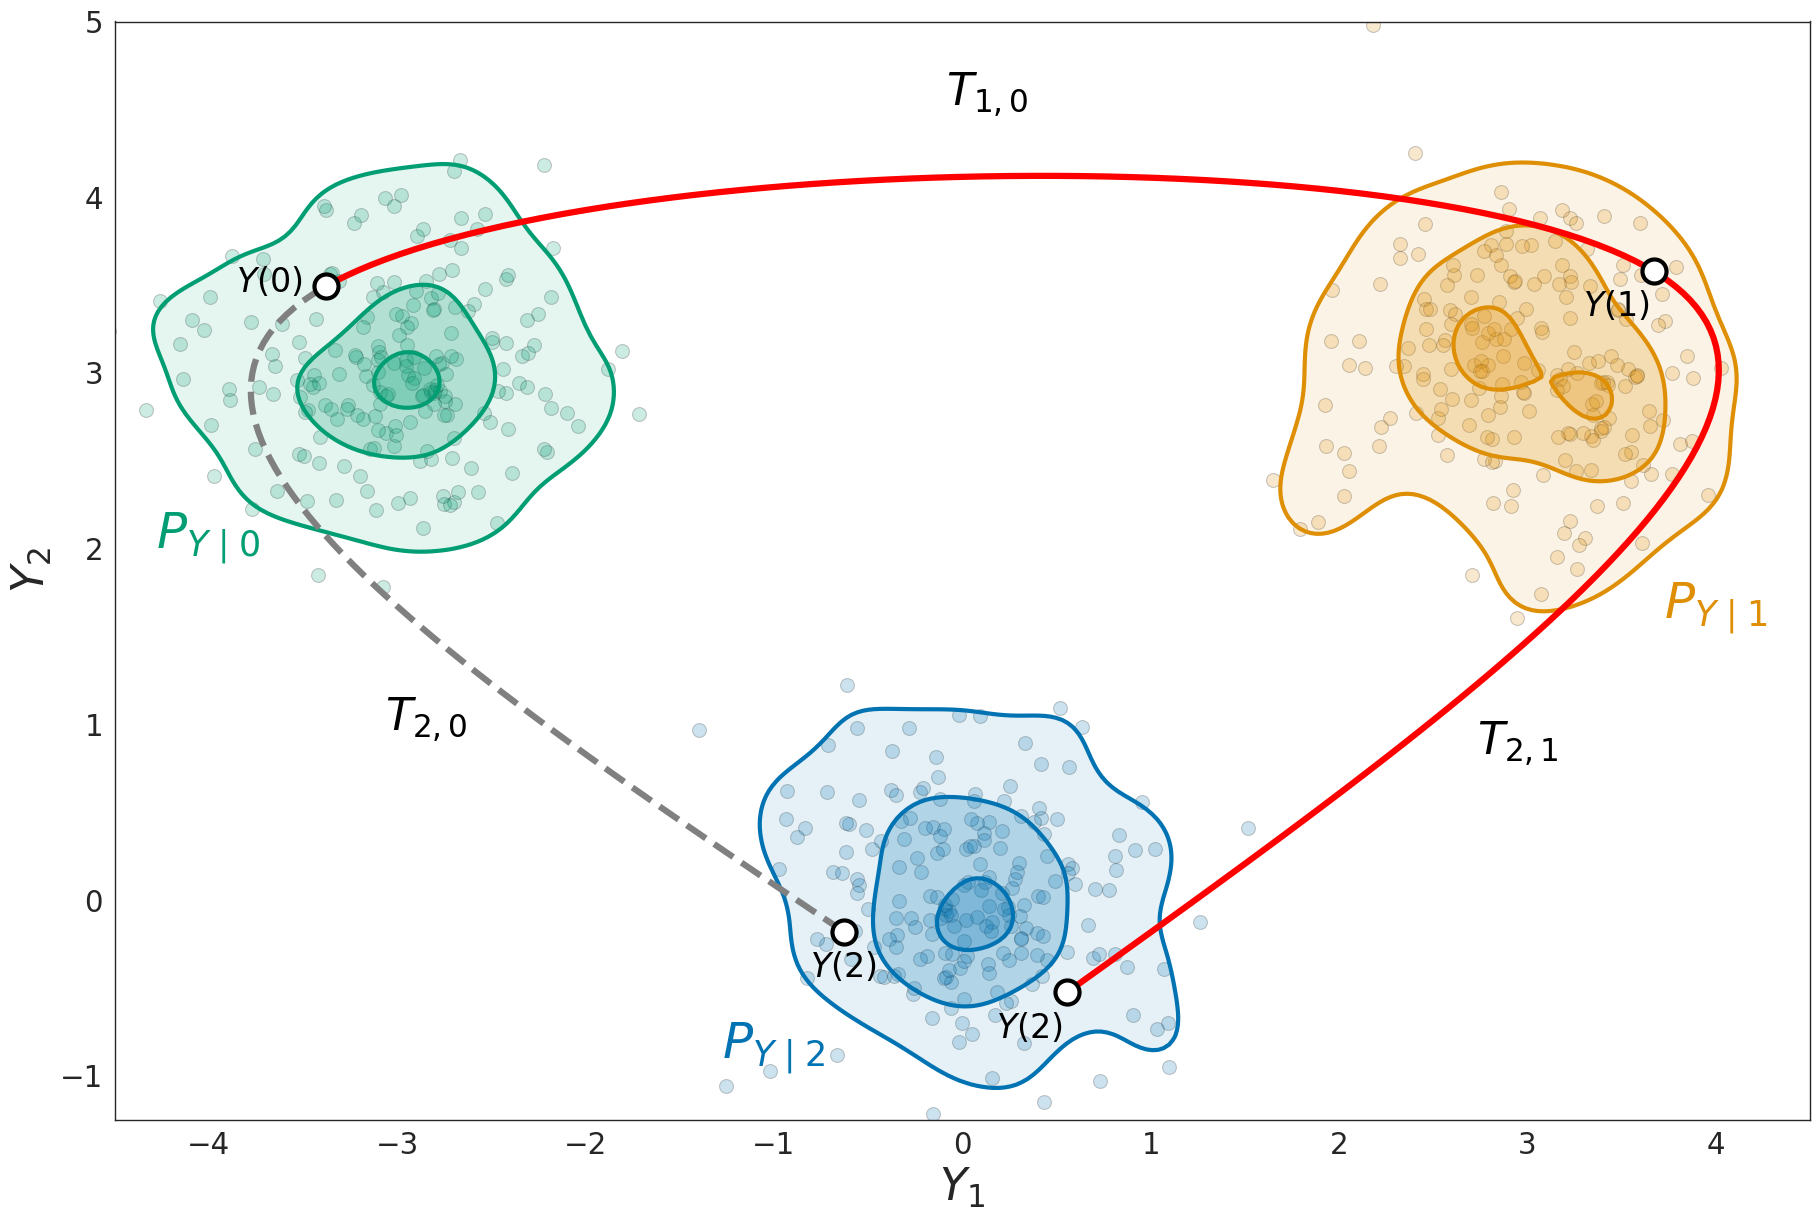

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde
import logging

# Suppress font_manager messages
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Seaborn style and colour‐blind palette
sns.set_style("white")
sns.set_context("paper", font_scale=2.4)
palette = sns.color_palette("colorblind", 3)

# -------------------------------  data  ------------------------------------- #
np.random.seed(1)
n_kde = 200
mean_P0 = np.array([0, 0])      # previously x_? -> now used for label {0,1,2} after rotation below
mean_P1 = np.array([3, 3])
mean_P2 = np.array([-3, 3])

samples0 = np.random.normal(loc=mean_P0, scale=0.5, size=(n_kde, 2))
samples1 = np.random.normal(loc=mean_P1, scale=0.5, size=(n_kde, 2))
samples2 = np.random.normal(loc=mean_P2, scale=0.5, size=(n_kde, 2))

# Grid for KDE
xmin, xmax, ymin, ymax = -4.5, 4.5, -2, 6
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300),
                     np.linspace(ymin, ymax, 300))
grid = np.vstack([xx.ravel(), yy.ravel()])

# Compute KDEs
Z0 = gaussian_kde(samples0.T)(grid).reshape(xx.shape)
Z1 = gaussian_kde(samples1.T)(grid).reshape(xx.shape)
Z2 = gaussian_kde(samples2.T)(grid).reshape(xx.shape)

# Contour‐thresholds (fractions of each peak)
fractions = [0.1, 0.5, 0.9]
L0 = [Z0.max()*f for f in fractions]
L1 = [Z1.max()*f for f in fractions]
L2 = [Z2.max()*f for f in fractions]

# figure
fig, ax = plt.subplots(figsize=(18, 12))

# ----- background scatter -----
for samples, col in zip((samples0, samples1, samples2), palette):
    ax.scatter(samples[:,0], samples[:,1],
               c=[col], s=100, alpha=0.2, edgecolor='black')

# ----- progressive HDR shading & contours -----
alphas = [0.1, 0.3, 0.5]   # light→dark for outer→inner
for Z, levels, col in zip((Z0, Z1, Z2), (L0, L1, L2), palette):
    low, mid, high = levels
    ax.contourf(xx, yy, Z, levels=[low, mid], colors=[col], alpha=alphas[0], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[mid, high], colors=[col], alpha=alphas[1], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[high, Z.max()], colors=[col], alpha=alphas[2], antialiased=True)
    ax.contour(xx, yy, Z, levels=[low, mid, high], colors=[col], linestyles='solid', linewidths=3)

# -------------------- trajectory points (use *tilde* ones) ------------------- #
scale = 0.3
P0       = np.random.normal(loc=mean_P0 + np.array([+0.5,-0.5]), scale=scale, size=(1, 2))
P0_inc   = np.random.normal(loc=mean_P0 + np.array([0.5,-0.5]),  scale=scale, size=(1, 2))
P1_cons  = np.random.normal(loc=mean_P1 + np.array([0.5,0]),     scale=scale, size=(1, 2))
P2_cons  = np.random.normal(loc=mean_P2 + np.array([-0.5,0.5]),  scale=scale, size=(1, 2))
P1_inc   = np.random.normal(loc=mean_P1 + np.array([0.5,0]),     scale=scale, size=(1, 2))
P2_inc   = np.random.normal(loc=mean_P2 + np.array([-0.7,0.7]),  scale=scale, size=(1, 2))
P0_alt   = np.random.normal(loc=mean_P0 + np.array([-0.5,-0.0]), scale=scale, size=(1, 2))

# Time knots and parameter
t_knots = np.array([0, 1/3, 2/3, 1])
t       = np.linspace(0, 1, 200)

# ---------------- single displayed trajectory ----------------
# Use the *tilde* control points but style/label it like the non-tilde T.
knots_single = np.vstack([P0_inc[0], P1_inc[0], P2_inc[0], P0_alt[0]])
cs_x   = CubicSpline(t_knots, knots_single[:,0], bc_type='natural')
cs_y   = CubicSpline(t_knots, knots_single[:,1], bc_type='natural')
x_s, y_s  = cs_x(t), cs_y(t)

# --- draw per-segment: two solid RED, one dashed GRAY ---
m1 = t <  t_knots[1]                      # P0_inc -> P1_inc  (T_{2,0})  RED
m2 = (t >= t_knots[1]) & (t < t_knots[2]) # P1_inc -> P2_inc  (T_{2,1})  RED
m3 = t >= t_knots[2]                      # P2_inc -> P0_alt  (T_{1,0})  dashed GRAY

ax.plot(x_s[m1], y_s[m1], color='red',  lw=4.5, ls='-',  solid_capstyle='round')
ax.plot(x_s[m2], y_s[m2], color='red',  lw=4.5, ls='-',  solid_capstyle='round')
ax.plot(x_s[m3], y_s[m3], color='gray', lw=4.5, ls='--', solid_capstyle='round')

# Knot markers
ax.scatter([knots_single[0,0], knots_single[1,0], knots_single[2,0], knots_single[3,0]],
           [knots_single[0,1], knots_single[1,1], knots_single[2,1], knots_single[3,1]],
           marker='o', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)

# ---------------- label updates: x0->1, x1->2, x2->0 ----------------
pairs = [
    (P0_inc, P1_inc, r'$T_{2,1}$'),
    (P1_inc, P2_inc, r'$T_{1,0}$'),
    (P2_inc, P0_alt, r'$T_{2,0}$'),
]
offset = -1.05
for start, end, label in pairs:
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]
    perp = np.array([-dy, dx])
    perp = perp / np.linalg.norm(perp)
    mid_x = mid_x + perp[0] * offset
    mid_y = mid_y + perp[1] * offset
    ax.text(mid_x, mid_y, label, fontsize=32, color='black',
            ha='center', va='center', backgroundcolor='white')

# Distribution labels
ax.text(mean_P0[0]-1.0, mean_P0[1]-0.9, r'$P_{Y\mid 2}$',
        color=palette[0], ha='center', fontsize=36)
ax.text(mean_P1[0]+1.0, mean_P1[1]-1.4, r'$P_{Y\mid 1}$',
        color=palette[1], ha='center', fontsize=36)
ax.text(mean_P2[0]-1.0, mean_P2[1]-1.0, r'$P_{Y\mid 0}$',
        color=palette[2], ha='center', fontsize=36)

# Point labels
ax.text(P2_inc[:,0]-0.3, P2_inc[:,1]+0.025, r"$Y(0)$", fontsize=24, color='black',
        ha='center', va='center')
ax.text(P1_inc[:,0]-0.2, P1_inc[:,1]-0.2, r"$Y(1)$", fontsize=24, color='black',
        ha='center', va='center')
ax.text(P0_inc[:,0]-0.2, P0_inc[:,1]-0.2, r"$Y(2)$", fontsize=24, color='black',
        ha='center', va='center')
ax.text(P0_alt[:,0], P0_alt[:,1]-0.2, r"$Y(2)$", fontsize=24, color='black',
        ha='center', va='center')

# Final styling
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin+0.75, ymax-1)
ax.set_xlabel(r"$Y_1$", fontsize=32)
ax.set_ylabel(r"$Y_2$", fontsize=32)

# No legend/caption
plt.tight_layout(pad=0)
plt.savefig("CPIproperty_single_rotated_selected2.png", bbox_inches="tight")
plt.show()

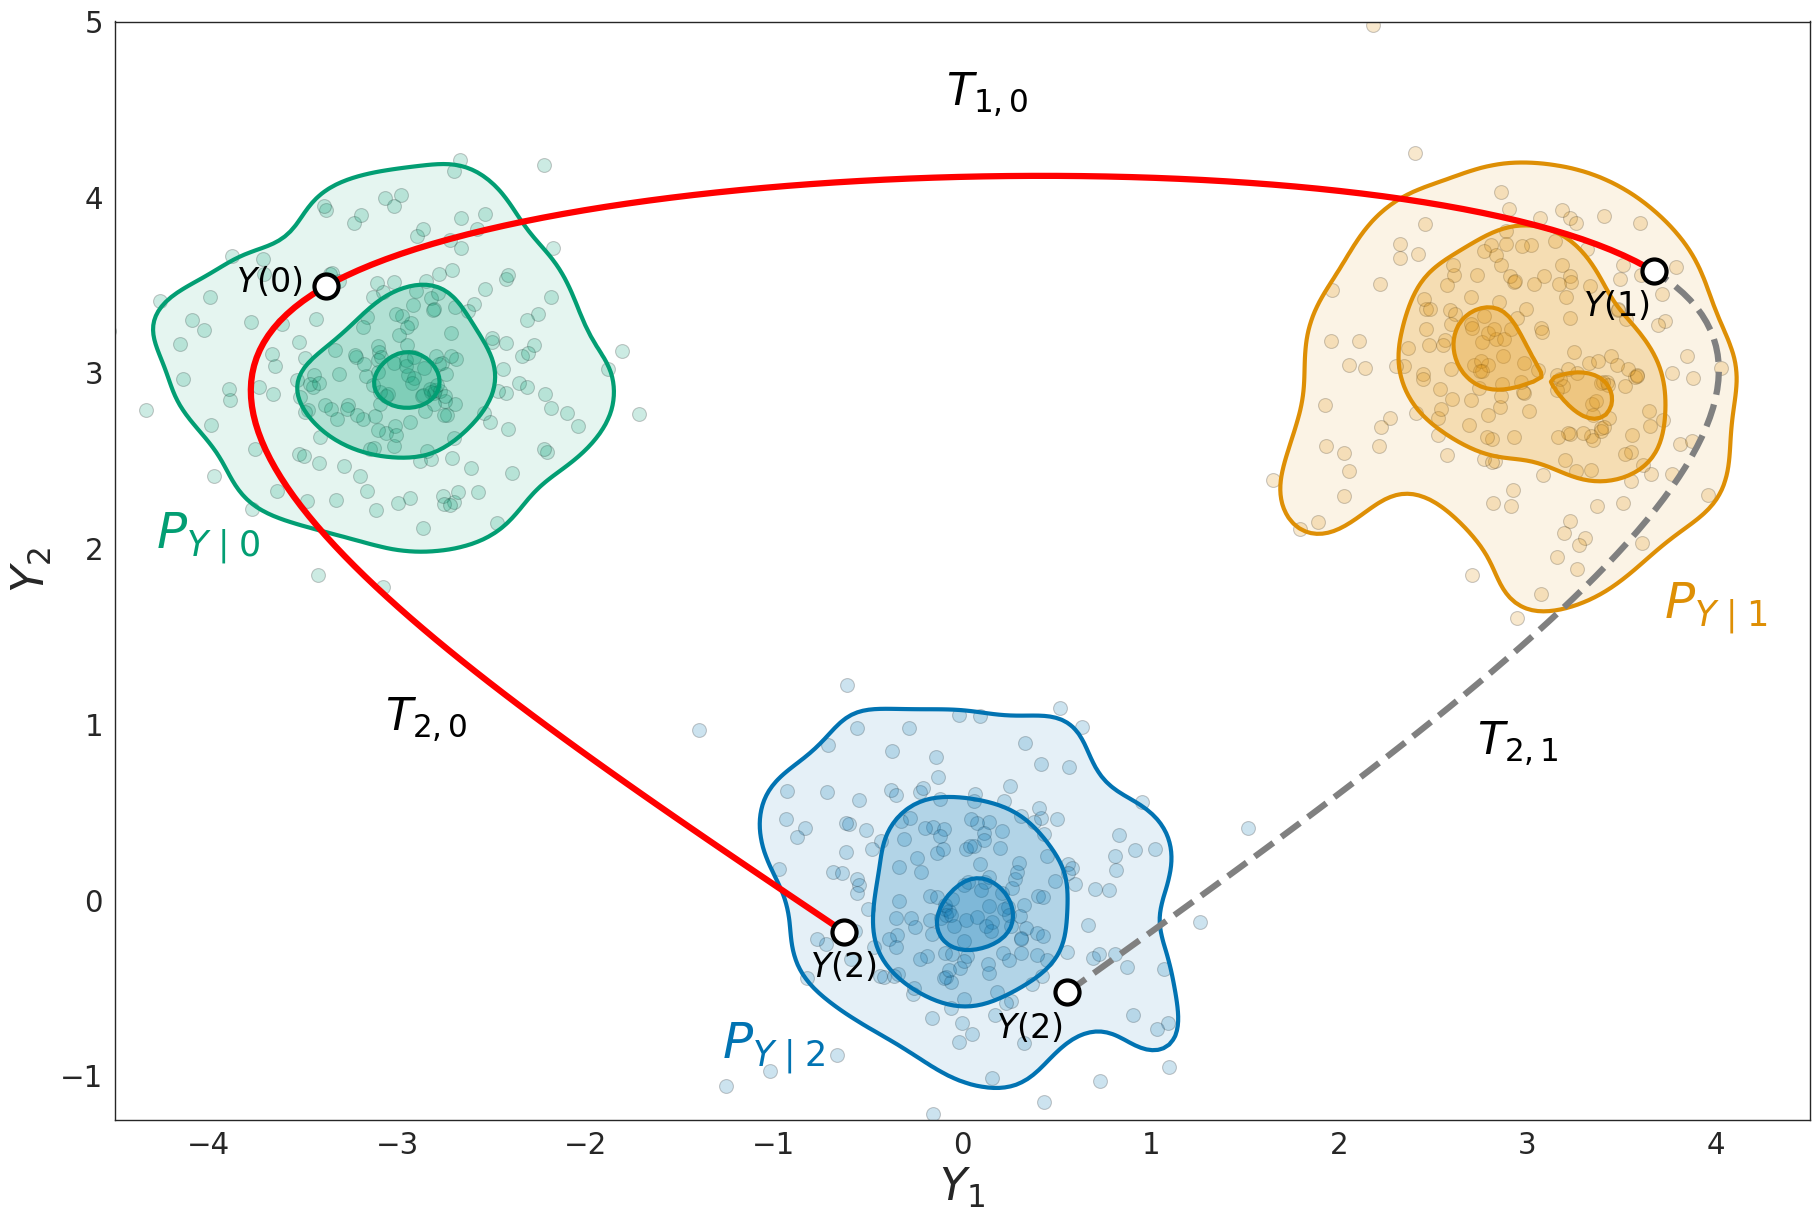

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde
import logging

# Suppress font_manager messages
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Seaborn style and colour‐blind palette
sns.set_style("white")
sns.set_context("paper", font_scale=2.4)
palette = sns.color_palette("colorblind", 3)

# -------------------------------  data  ------------------------------------- #
np.random.seed(1)
n_kde = 200
mean_P0 = np.array([0, 0])      # previously x_? -> now used for label {0,1,2} after rotation below
mean_P1 = np.array([3, 3])
mean_P2 = np.array([-3, 3])

samples0 = np.random.normal(loc=mean_P0, scale=0.5, size=(n_kde, 2))
samples1 = np.random.normal(loc=mean_P1, scale=0.5, size=(n_kde, 2))
samples2 = np.random.normal(loc=mean_P2, scale=0.5, size=(n_kde, 2))

# Grid for KDE
xmin, xmax, ymin, ymax = -4.5, 4.5, -2, 6
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300),
                     np.linspace(ymin, ymax, 300))
grid = np.vstack([xx.ravel(), yy.ravel()])

# Compute KDEs
Z0 = gaussian_kde(samples0.T)(grid).reshape(xx.shape)
Z1 = gaussian_kde(samples1.T)(grid).reshape(xx.shape)
Z2 = gaussian_kde(samples2.T)(grid).reshape(xx.shape)

# Contour‐thresholds (fractions of each peak)
fractions = [0.1, 0.5, 0.9]
L0 = [Z0.max()*f for f in fractions]
L1 = [Z1.max()*f for f in fractions]
L2 = [Z2.max()*f for f in fractions]

# figure
fig, ax = plt.subplots(figsize=(18, 12))

# ----- background scatter -----
for samples, col in zip((samples0, samples1, samples2), palette):
    ax.scatter(samples[:,0], samples[:,1],
               c=[col], s=100, alpha=0.2, edgecolor='black')

# ----- progressive HDR shading & contours -----
alphas = [0.1, 0.3, 0.5]   # light→dark for outer→inner
for Z, levels, col in zip((Z0, Z1, Z2), (L0, L1, L2), palette):
    low, mid, high = levels
    ax.contourf(xx, yy, Z, levels=[low, mid], colors=[col], alpha=alphas[0], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[mid, high], colors=[col], alpha=alphas[1], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[high, Z.max()], colors=[col], alpha=alphas[2], antialiased=True)
    ax.contour(xx, yy, Z, levels=[low, mid, high], colors=[col], linestyles='solid', linewidths=3)

# -------------------- trajectory points (use *tilde* ones) ------------------- #
scale = 0.3
P0       = np.random.normal(loc=mean_P0 + np.array([+0.5,-0.5]), scale=scale, size=(1, 2))
P0_inc   = np.random.normal(loc=mean_P0 + np.array([0.5,-0.5]),  scale=scale, size=(1, 2))
P1_cons  = np.random.normal(loc=mean_P1 + np.array([0.5,0]),     scale=scale, size=(1, 2))
P2_cons  = np.random.normal(loc=mean_P2 + np.array([-0.5,0.5]),  scale=scale, size=(1, 2))
P1_inc   = np.random.normal(loc=mean_P1 + np.array([0.5,0]),     scale=scale, size=(1, 2))
P2_inc   = np.random.normal(loc=mean_P2 + np.array([-0.7,0.7]),  scale=scale, size=(1, 2))
P0_alt   = np.random.normal(loc=mean_P0 + np.array([-0.5,-0.0]), scale=scale, size=(1, 2))

# Time knots and parameter
t_knots = np.array([0, 1/3, 2/3, 1])
t       = np.linspace(0, 1, 200)

# ---------------- single displayed trajectory ----------------
# Use the *tilde* control points but style/label it like the non-tilde T.
knots_single = np.vstack([P0_inc[0], P1_inc[0], P2_inc[0], P0_alt[0]])
cs_x   = CubicSpline(t_knots, knots_single[:,0], bc_type='natural')
cs_y   = CubicSpline(t_knots, knots_single[:,1], bc_type='natural')
x_s, y_s  = cs_x(t), cs_y(t)

# --- draw per-segment: left two (m2 & m3) solid RED, right segment (m1) dashed GRAY ---
m1 = t <  t_knots[1]                      # P0_inc -> P1_inc  (right edge)   dashed GRAY
m2 = (t >= t_knots[1]) & (t < t_knots[2]) # P1_inc -> P2_inc  (top-left)     RED
m3 = t >= t_knots[2]                      # P2_inc -> P0_alt  (left-down)    RED

ax.plot(x_s[m1], y_s[m1], color='gray', lw=4.5, ls='--', solid_capstyle='round')
ax.plot(x_s[m2], y_s[m2], color='red',  lw=4.5, ls='-',  solid_capstyle='round')
ax.plot(x_s[m3], y_s[m3], color='red',  lw=4.5, ls='-',  solid_capstyle='round')

# Knot markers
ax.scatter([knots_single[0,0], knots_single[1,0], knots_single[2,0], knots_single[3,0]],
           [knots_single[0,1], knots_single[1,1], knots_single[2,1], knots_single[3,1]],
           marker='o', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)

# ---------------- label updates: x0->1, x1->2, x2->0 ----------------
pairs = [
    (P0_inc, P1_inc, r'$T_{2,1}$'),
    (P1_inc, P2_inc, r'$T_{1,0}$'),
    (P2_inc, P0_alt, r'$T_{2,0}$'),
]
offset = -1.05
for start, end, label in pairs:
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]
    perp = np.array([-dy, dx])
    perp = perp / np.linalg.norm(perp)
    mid_x = mid_x + perp[0] * offset
    mid_y = mid_y + perp[1] * offset
    ax.text(mid_x, mid_y, label, fontsize=32, color='black',
            ha='center', va='center', backgroundcolor='white')

# Distribution labels
ax.text(mean_P0[0]-1.0, mean_P0[1]-0.9, r'$P_{Y\mid 2}$',
        color=palette[0], ha='center', fontsize=36)
ax.text(mean_P1[0]+1.0, mean_P1[1]-1.4, r'$P_{Y\mid 1}$',
        color=palette[1], ha='center', fontsize=36)
ax.text(mean_P2[0]-1.0, mean_P2[1]-1.0, r'$P_{Y\mid 0}$',
        color=palette[2], ha='center', fontsize=36)

# Point labels
ax.text(P2_inc[:,0]-0.3, P2_inc[:,1]+0.025, r"$Y(0)$", fontsize=24, color='black',
        ha='center', va='center')
ax.text(P0_inc[:,0]-0.2, P0_inc[:,1]-0.2, r"$Y(2)$", fontsize=24, color='black',
        ha='center', va='center')
ax.text(P1_inc[:,0]-0.2, P1_inc[:,1]-0.2, r"$Y(1)$", fontsize=24, color='black',
        ha='center', va='center')
ax.text(P0_alt[:,0], P0_alt[:,1]-0.2, r"$Y(2)$", fontsize=24, color='black',
        ha='center', va='center')

# Final styling
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin+0.75, ymax-1)
ax.set_xlabel(r"$Y_1$", fontsize=32)
ax.set_ylabel(r"$Y_2$", fontsize=32)

# No legend/caption
plt.tight_layout(pad=0)
plt.savefig("CPIproperty_single_rotated_selected1.png", bbox_inches="tight")
plt.show()

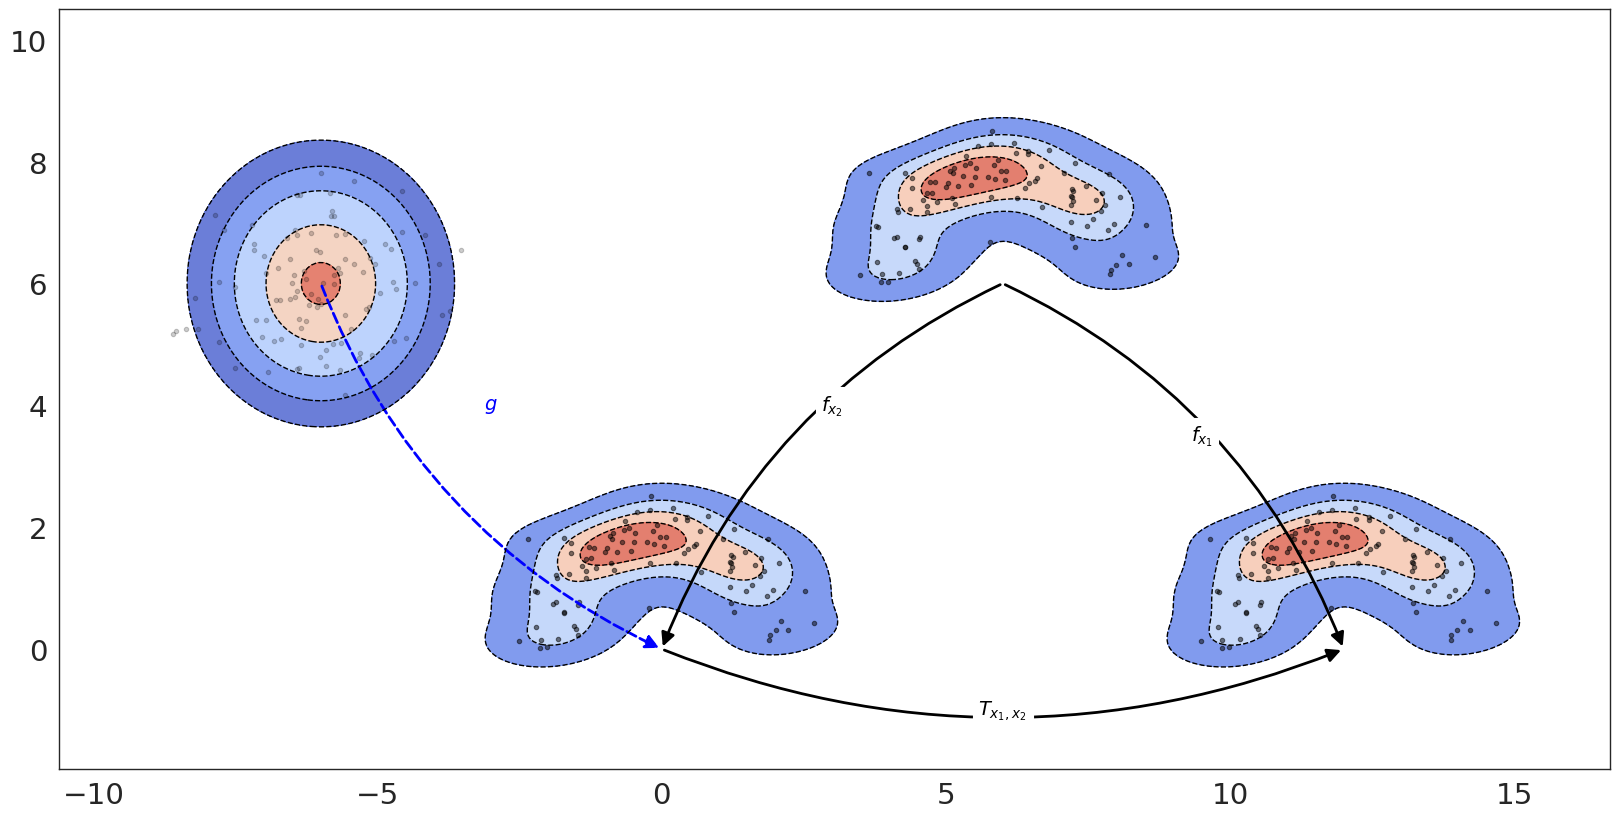

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, multivariate_normal
from matplotlib.patches import FancyArrowPatch

# Style
sns.set_style("white")
sns.set_context("paper", font_scale=2.4)

# Parameters (doubled)
a = 6.0  # vertical shift
b = 12.0  # horizontal shift
n = 100  # sample size

# Generate half-moon base distribution at origin
angles = np.random.rand(n) * np.pi
r = 2 + 0.3 * np.random.randn(n)
base = np.vstack((r * np.cos(angles), r * np.sin(angles))).T

# Shifted half-moons
hm1 = base + np.array([0.0, 0.0])       # (0,0)
hm2 = base + np.array([b, 0.0])         # (b,0)
hm3 = base + np.array([b/2.0, a])       # (b/2,a)

# Standard Gaussian at (-b, a)
mean_g = np.array([-b/2, a])
cov_g = np.eye(2)
gauss_samples = np.random.multivariate_normal(mean_g, cov_g, size=n)
rv = multivariate_normal(mean=mean_g, cov=cov_g)

# Setup figure
fig, ax = plt.subplots(figsize=(16, 8))

# Create grid that covers all distributions
all_points = np.vstack([hm1, hm2, hm3, gauss_samples])
padding = 2.0
xmin, xmax = all_points[:,0].min() - padding, all_points[:,0].max() + padding
ymin, ymax = all_points[:,1].min() - padding, all_points[:,1].max() + padding
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 400),
                     np.linspace(ymin, ymax, 400))
grid = np.vstack([xx.ravel(), yy.ravel()]).T

# Colormap
cmap = plt.get_cmap('coolwarm')

# Contour levels (shared across all)
num_levels = 5

# Plot Gaussian contour and points
Zg = rv.pdf(grid).reshape(xx.shape)
vmin = Zg.max() * 0.05  # 5% of the peak density
levels_g = np.array([0.01,0.025,0.05,0.1,0.15, 0.2])
cf = ax.contourf(xx, yy, Zg, levels=levels_g, cmap=cmap, alpha=0.8)
ax.contour(xx, yy, Zg, levels=levels_g, colors='k', linestyles='--', linewidths=1)
ax.scatter(gauss_samples[:,0], gauss_samples[:,1], color='k', s=10, alpha=0.2)

# Function to plot half-moon KDE contours and points
def plot_kde(data, points_color='k'):
    kde = gaussian_kde(data.T)
    Z = kde(grid.T).reshape(xx.shape)
    vmin = Z.max() * 0.1  # 5% of the peak density
    levels = np.linspace(vmin, Z.max(), num_levels)
    ax.contourf(xx, yy, Z, levels=levels, cmap=cmap, alpha=0.8)
    ax.contour(xx, yy, Z, levels=levels, colors='k', linestyles='--', linewidths=1)
    ax.scatter(data[:,0], data[:,1], color=points_color, alpha=0.5, s=10)

# Plot each half-moon
plot_kde(hm1)
plot_kde(hm2)
plot_kde(hm3)

# Add arrows between centers
centers = {
    'G':  mean_g,
    'HM1': np.array([0.0, 0.0]),
    'HM2': np.array([b, 0.0]),
    'HM3': np.array([b/2.0, a]),
}

def draw_arrow(start, end, text, text_offset=(0, 0), color='black', style='-', lw=2, rad=0.2,scale = 20):
    arrow = FancyArrowPatch(start, end,
                            connectionstyle=f"arc3,rad={rad}",
                            arrowstyle='-|>', mutation_scale=scale,
                            lw=lw, linestyle=style, color=color)
    ax.add_patch(arrow)
    mid = (np.array(start) + np.array(end)) / 2 + np.array(text_offset)
    ax.text(mid[0], mid[1], text, fontsize=14, color=color,
            ha='center', va='center', backgroundcolor='white')

# Arrows
draw_arrow(centers['G'], centers['HM1'], r'$g$', text_offset=(0, 1), color='blue', style='--')
draw_arrow(centers['HM1'], centers['HM2'], r'$T_{x_1,x_2}$', text_offset=(0, -1), color='black')
draw_arrow(centers['HM3'], centers['HM2'], r'$f_{x_1}$', text_offset=(0.5, 0.5), color='black', rad = -0.2)
draw_arrow(centers['HM3'], centers['HM1'], r'$f_{x_2}$', text_offset=(0, 1), color='black')

# Final styling
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
#ax.axis('off')
plt.tight_layout(pad=0)
plt.show()